<img src="../assets/header_notebook.png" />
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>ESA - Black Sea Deoxygenation Emulator</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# ----------
# Librairies
# ----------
import os
import sys
import cv2
import dawgz
import wandb
import xarray
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Dawgz (jobs //)
from dawgz import job, schedule

# -------------------
# Librairies (Custom)
# -------------------
# Adding path to source folder to load custom modules
sys.path.append('/src')
sys.path.append('/src/debs/')
sys.path.insert(1, '/src/debs/')
sys.path.insert(1, '/scripts/')

# Moving to the .py directory
%cd src/debs/

## Loading libraries
from metrics     import *
from dataset     import *
from dataloader  import *
from tools       import *
from losses      import *

# -------
# Jupyter
# -------
%matplotlib inline
plt.rcParams.update({'font.size': 13})

# Making sure modules are reloaded when modified
%reload_ext autoreload
%autoreload 2

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Scripts</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# Generating the preprocessed data (normalized)
%run __generate_n.py

In [ ]:
# Generating the preprocessed data (standardized)
%run __generate_s.py

In [ ]:
# Analyzing the data distributions
%run __distributions.py

In [ ]:
# Training a neural network (using a given configuration)
%run __training.py --config local

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Dataset.py</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# -------------------------------------------------------
#
#        |
#       / \
#      / _ \                  ESA - PROJECT
#     |.o '.|
#     |'._.'|          BLACK SEA DEOXYGENATION EMULATOR
#     |     |
#   ,'|  |  |`.             BY VICTOR MANGELEER
#  /  |  |  |  \
#  |,-'--|--'-.|                2023-2024
#
#
# -------------------------------------------------------
#
# Documentation
# -------------
# A tool to load training (1980 to 2014), validation (2015 to 2019) and test (2020 to 2022) standardized Black Sea datasets coming from the NEMO simulator.
#
import os
import xarray
import numpy as np


class BlackSea_Dataset():
    r"""A simple tool to load data of Black Sea simulations (NEMO Simulator)"""

    def __init__(self, dataset_type: str = "Training"):

        # Security
        assert dataset_type in ["Training", "Validation", "Test"], f"ERROR (BlackSea_Dataset), Incorrect dataset type ({dataset_type})"

        # Path to cluster files
        path = f"../../../../../../../scratch/acad/bsmfc/victor/data/deep_learning/{dataset_type}/"

        # Creation of the files name
        month_start, month_end, year_start, year_end = 1, 12, 0, 0

        if dataset_type == "Training":
            year_start, year_end = 1980, 2014
        elif dataset_type == "Validation":
            year_start, year_end = 2015, 2019
        else:
            year_start, year_end = 2020, 2022

        files = [path + f"BlackSea-DeepLearning_Standardized_{y}_{m}.nc" for y in range(year_start, year_end + 1) for m in range(1, 13)]

        # Loading the data and saving other relevant information
        self.data        = xarray.open_mfdataset(files, combine = 'nested', concat_dim = "time").compute()
        self.data_type   = dataset_type
        self.month_start = month_start
        self.month_end   = month_end
        self.year_start  = year_start
        self.year_end    = year_end

    def get_data(self, variable: str):
        """ Used to access the input/output data more clearly"""

        # Security
        assert variable in ["temperature", "salinity", "chlorophyll", "height", "oxygen"], f"ERROR (get_data), Incorrect variable ({variable})"

        # Stores the translations
        translations = {"temperature": "TEM", "salinity": "SAL", "chlorophyll": "CHL", "height": "SSH", "oxygen": "OXYCS"}

        # Extracting the data
        return self.data[translations[variable]].data

    def get_mesh(self, x: int = 256, y: int = 576):
        r"""Used to retrieve a mesh with normalized coordinates for the given shape (x, y)"""

        # Creation of the mesh
        x_mesh, y_mesh = np.meshgrid(np.linspace(0, 1, num = x), np.linspace(0, 1, num = y), indexing = 'ij')

        # Concatenation of the mesh (np.float32 is the type needed for torch when converted afterforwards)
        return np.stack((x_mesh, y_mesh), axis = 0, dtype = np.float32)

    def get_depth(self, unit: str = "index"):
        """Used to retrieve the maximum depths position (indexes in 3D data) or the maximum depths values (in meters)"""

        # Security
        assert unit in ["index", "meter"], f"ERROR (get_depth), Incorrect unit ({unit})"

        # Loading the data
        depths = self.data["BATHYM"].data[0] if unit == "meter" else self.data["BATHYI"].data[0]

        # Returning with an additional dimension
        return np.expand_dims(depths, axis = 0)

    def get_mask(self, continental_shelf: bool = False):
        r"""Used to retreive a mask of the Black Sea, i.e. 0 if land, 1 if the Black Sea. If depth is given, it will also set to 0 all regions below that depth"""

        # Loading the data
        mask = self.data["MASK"].data[0] if continental_shelf == False else self.data["MASKCS"].data[0]

        # Returning with an additional dimension
        return np.expand_dims(mask, axis = 0)

    def get_treshold(self, standardized = False):
        r"""Used to retrieve the hypoxia treshold value, i.e. the oxygen concentration below which hypoxia is considered to occur"""
        return self.data["HYPOXIA_STANDARDIZED"].data[0] if standardized else self.data["HYPOXIA"].data[0]

    def get_mean(self, variable: str):
        """Used to retreive the mean value of a variable for a given dataset type"""

        # Security
        assert variable in ["temperature", "salinity", "chlorophyll", "height", "oxygen"], f"ERROR (get_data), Incorrect variable ({variable})"

        # Stores the translations
        translations = {"temperature": "TMEAN", "salinity": "SMEAN", "chlorophyll": "CMEAN", "height": "HMEAN", "oxygen": "OMEAN"}

        # Extracting the data
        return self.data[translations[variable]].data[0]

    def get_standard_deviation(self, variable: str):
        """Used to retreive the stand value of a variable for a given dataset type"""

        # Security
        assert variable in ["temperature", "salinity", "chlorophyll", "height", "oxygen"], f"ERROR (get_data), Incorrect variable ({variable})"

        # Stores the translations
        translations = {"temperature": "TSTD", "salinity": "SSTD", "chlorophyll": "CSTD", "height": "HSTD", "oxygen": "OSTD"}

        # Extracting the data
        return self.data[translations[variable]].data[0]

    def get_time(self):
        """Generate time information about the dataset, i.e. for each day, retrieves the relative index, the month and year"""

        # Used to play easily with dates
        from datetime import datetime, timedelta

        # Helper functions
        def get_index_day(date):
            """Get the index of the day in the year"""
            return date.timetuple().tm_yday

        def get_index_month(date):
            """Get the index of the month in the year"""
            return date.month

        def get_index_year(date):
            """Get the year associated with the given date"""
            return date.year

        # Conversion of the date to appropriate format
        start_date = datetime(self.year_start, 1,   1)
        end_date   = datetime(self.year_end,  12,  31)

        # Creation of the dates
        num_days    = (end_date - start_date).days + 1
        dates       = [start_date + timedelta(days = i) for i in range(num_days)]
        index_day   = np.array([get_index_day(date)   for date in dates])
        index_month = np.array([get_index_month(date) for date in dates])
        index_year  = np.array([get_index_year(date)  for date in dates])

        return index_day, index_month, index_year

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Dataloader.py</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# -------------------------------------------------------
#
#        |
#       / \
#      / _ \                  ESA - PROJECT
#     |.o '.|
#     |'._.'|          BLACK SEA DEOXYGENATION EMULATOR
#     |     |
#   ,'|  |  |`.             BY VICTOR MANGELEER
#  /  |  |  |  \
#  |,-'--|--'-.|                2023-2024
#
#
# -------------------------------------------------------
#
# Documentation
# -------------
# A tool to create a dataloader that processes data on the fly
#
import numpy as np

# Torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Custom Librairies
from dataset import BlackSea_Dataset


class BlackSea_Dataloader():
   r"""A tool to create a dataloader that processes and loads the Black Sea datasets on the fly"""

   def __init__(self, dataset: BlackSea_Dataset,
                 window_input: int = 1,
                window_output: int = 10,
                   batch_size: int = 1,
                  num_workers: int = 2):

      # Extracting the data
      temperature = dataset.get_data("temperature")
      salinity    = dataset.get_data("salinity")
      chlorophyll = dataset.get_data("chlorophyll")
      height      = dataset.get_data("height")
      oxygen      = dataset.get_data("oxygen")

      # Creation of the input/output data
      self.x, self.y = np.stack([temperature, salinity, chlorophyll, height], axis = 1), oxygen

      # Extracting time information
      self.time_day, self.time_month, self.time_year = dataset.get_time()

      # Corresponds to the number of samples used as "buffer"
      self.nb_buffered_samples = 365

      # Storing other information
      self.window_input  = window_input
      self.window_output = window_output
      self.batch_size    = batch_size
      self.num_workers   = num_workers
      self.mesh          = dataset.get_mesh()
      self.mask          = dataset.get_mask(continental_shelf = False)
      self.mask_CS       = dataset.get_mask(continental_shelf = True)
      self.bathymetry    = dataset.get_depth(unit = "meter")

   def get_number_of_samples(self):
      r"""Returns the number of samples in the dataset"""
      return self.x.shape[0] - self.nb_buffered_samples - self.window_output

   def get_dataloader(self):
         r"""Creates and returns a dataloader"""

         class BS_Dataset(Dataset):
               r"""Pytorch dataloader"""

               def __init__(self, x: np.array,
                                  y: np.array,
                               mesh: np.array,
                               mask: np.array,
                           time_day: np.array,
                         time_month: np.array,
                          time_year: np.array,
                         bathymetry: np.array,
                       window_input: int,
                      window_output: int,
                nb_samples_buffered: int):

                  # Initialization
                  self.x                   = x
                  self.y                   = y
                  self.mesh                = mesh
                  self.mask                = mask
                  self.time_day            = time_day
                  self.time_month          = time_month
                  self.time_year           = time_year
                  self.bathymetry          = bathymetry
                  self.window_input        = window_input
                  self.window_output       = window_output
                  self.x_res               = self.x.shape[2]
                  self.y_res               = self.x.shape[3]
                  self.nb_buffered_samples = nb_samples_buffered
                  self.time_img            = np.ones((self.x_res, self.y_res))

               def process(self, index : int):
                  """Used as a processing pipeline, i.e. it fetch and process a single data sample"""

                  # Determination of the indexes to perform the extraction
                  index_t        = self.nb_buffered_samples + index + 1
                  index_t_before = self.nb_buffered_samples + index + 1 - self.window_input
                  index_t_after  = self.nb_buffered_samples + index     + self.window_output

                  # Extracting the input and output
                  x = self.x[index_t_before : index_t]
                  y = self.y[index_t - 1    : index_t_after]

                  # Creation of temporal data
                  t = np.stack([self.time_img * self.time_day[index_t],
                                self.time_img * self.time_month[index_t],
                                self.time_img * self.time_year[index_t]], axis = 0)

                  # Merging window intputs with physical variables values
                  x = x.reshape((-1, self.x_res, self.y_res))

                  # Masking the useless information (maybe needs to be changed)
                  x = np.where(self.mask == 0, 0, x)

                  # Stacking all the information
                  x = np.concatenate([x, self.mesh, self.bathymetry, t], axis = 0)

                  # Returning the preprocessed samples (format changed for pytorch)
                  return x.astype(np.float32), y.astype(np.float32)

               def __len__(self):
                  return self.x.shape[0] - self.nb_buffered_samples - self.window_output

               def __getitem__(self, idx):
                  return self.process(index = idx)

         # Creation of the dataset for dataloader
         dataset = BS_Dataset(x = self.x,
                              y = self.y,
                           mesh = self.mesh,
                           mask = self.mask,
                       time_day = self.time_day,
                     time_month = self.time_month,
                      time_year = self.time_year,
                     bathymetry = self.bathymetry,
                   window_input = self.window_input,
                  window_output = self.window_output,
            nb_samples_buffered = self.nb_buffered_samples)

         # Creation of the dataloader
         return DataLoader(dataset, batch_size = self.batch_size, num_workers = self.num_workers)

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Training</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
kwargs = {
    "Project" : "Test",
    "Window (Inputs)" : 1,
    "Window (Outputs)" : 10,
    "Architecture" : "UNET",
    "Learning Rate" : 0.001,
    "Batch Size" : 4,
    "Epochs" : 1,
    'Number of Workers' : 0,
    "Scaling" : 1,
    "Kernel Size" : 3,
    "Mode" : "disabled"
}

In [ ]:
# -------------------------------------------------------
#
#        |
#       / \
#      / _ \                  ESA - PROJECT
#     |.o '.|
#     |'._.'|          BLACK SEA DEOXYGENATION EMULATOR
#     |     |
#   ,'|  |  |`.             BY VICTOR MANGELEER
#  /  |  |  |  \
#  |,-'--|--'-.|                2023-2024
#
#
# -------------------------------------------------------
#
# Documentation
# -------------
# Function used to train a neural network to forecast the oxygen concentration in the Black Sea.
#
import time
import wandb
import xarray
import calendar
import numpy as np

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Custom libraries
from metrics                import *
from tools                  import *
from losses                 import *
from dataset                import BlackSea_Dataset
from dataloader             import BlackSea_Dataloader
from neural_networks.loader import load_neural_network


# -------------—---------
#     Initialization
# -------------—---------
#
# Information over terminal (1)
project_title(kwargs)

# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fixing random seed for reproducibility
np.random.seed(2701)
torch.manual_seed(2701)

# Loading configuration
project        = kwargs['Project']
mode           = kwargs['Mode']
window_input   = kwargs['Window (Inputs)']
window_output  = kwargs['Window (Outputs)']
architecture   = kwargs['Architecture']
learning_rate  = kwargs['Learning Rate']
batch_size     = kwargs['Batch Size']
nb_epochs      = kwargs['Epochs']
num_workers    = kwargs['Number of Workers']

# -------------—---------
#     Loading the data
# -------------—---------
# training   = BlackSea_Dataset("Training")
validation = BlackSea_Dataset("Validation")
test       = BlackSea_Dataset("Test")

# Extracting the output (used by AverageNET)
data_oxygen = training.get_data(variable = "oxygen")

# Loading the different masks
bs_mask             = training.get_mask(continental_shelf = False)
bs_mask_with_depth  = training.get_mask(continental_shelf = True)

# Hypoxia treshold
hypox_tresh = training.get_treshold(standardized = True)

In [ ]:
# Extracting the output (used by AverageNET)
data_oxygen = validation.get_data(variable = "oxygen")

# Loading the different masks
bs_mask             = validation.get_mask(continental_shelf = False)
bs_mask_with_depth  = validation.get_mask(continental_shelf = True)

# Hypoxia treshold
hypox_tresh = validation.get_treshold(standardized = True)

In [ ]:
# -------------—---------
#     Preprocessing
# -------------—---------
# BS_loader_train      = BlackSea_Dataloader(training,   window_input, window_output,  batch_size, num_workers)
BS_loader_validation = BlackSea_Dataloader(validation, window_input, window_output,  batch_size, num_workers)
BS_loader_test       = BlackSea_Dataloader(test,       window_input, window_output,  batch_size, num_workers)

# Creating the dataloaders
#dataset_train        = BS_loader_train.get_dataloader()
dataset_validation   = BS_loader_validation.get_dataloader()
dataset_test         = BS_loader_test.get_dataloader()

In [ ]:
# -------------—--------------------
#     Neural Network & Training
# -------------—--------------------
# Initialization of the neural network
neural_net = load_neural_network(architecture = architecture, data_output = data_oxygen, device = device, kwargs = kwargs)
neural_net.to(device)

# Loading the optimizer
optimizer  = optim.Adam(neural_net.parameters(), lr = learning_rate)

In [ ]:
neural_net.to(device)

In [ ]:
# WandB (1) - Initialization of the run
wandb.init(project = project, mode = mode, config = kwargs)

# Used to compute the total time left,
epoch_time = 0.0

# ------- Training Loop -------
for epoch in range(nb_epochs):

  # Timing the epoch
  start = time.time()

  # Used to store and compute instantaneous training loss
  loss_training_total, loss_training_per_day, loss_training_index = 0.0, list(), 0

  # Training the neural network
  for x, y in dataset_test:

    # Pushing the data to the correct device
    x, y = x.to(device), y.to(device)

    # Forward pass
    pred = neural_net.forward(x)

    # Computing the training loss
    loss_training_batch_total, loss_training_batch_per_day = forecasting_loss(y_true = y,
                                                                              y_pred = pred,
                                                                                mask = bs_mask_with_depth)

    # Accumulating the total loss, storing losses per day and updating the number of training steps
    loss_training_total += loss_training_batch_total.item()
    loss_training_index += 1
    loss_training_per_day.append([l.item() for l in loss_training_batch_per_day])

    # AverageNet : No optimization needed !
    if architecture == "AVERAGE":
        continue

    # Reseting the gradients
    optimizer.zero_grad()

    # Backward pass
    loss_training_batch_total.backward()

    # Optimizing the parameters
    optimizer.step()

    # Freeing the GPU
    x, y, pred = x.to("cpu"), y.to("cpu"), pred.to("cpu")

    # WandB (2.1) - Sending information about the training results
    wandb.log({f"Training/Loss (T)": loss_training_batch_total.item()})
    wandb.log({f"Training/Loss (T, {i})": loss.item() for i, loss in enumerate(loss_training_batch_per_day)})

    # Freeing memory
    del x, y, pred, loss_training_batch_total, loss_training_batch_per_day

  # WandB (2.2) - Sending information about the training results
  wandb.log({f"Training/Loss (Training): ": loss_training_total / loss_training_index})

  with torch.no_grad():

    # Used to store and compute instantaneous training loss
    loss_validation_total, loss_validation_per_day, loss_validation_index = 0.0, list(), 0

    # Used to store all predictions and ground truth
    validation_predictions, validation_ground_truth = None, None

    # Used to store temporal information
    time_days, time_months, time_years = list(), list(), list()

    # Validating the neural network
    for x, y in dataset_validation:

      # Pushing the data to the correct device
      x, y = x.to(device), y.to(device)

      # Prediction of the neural network
      pred = neural_net.forward(x)

      # Computing the validation loss
      loss_validation_batch_total, loss_validation_batch_per_day = forecasting_loss(y_true = y,
                                                                                    y_pred = pred,
                                                                                      mask = bs_mask_with_depth)

      # Accumulating the total loss, storing losses per day and updating the number of training steps
      loss_validation_total += loss_validation_batch_total.item()
      loss_validation_index += 1
      loss_validation_per_day.append([l.item() for l in loss_validation_batch_per_day])

      # Pushing everything back to the CPU
      x, y, pred = x.to("cpu"), y.to("cpu"), pred.to("cpu")

      # WandB (3.1) - Sending information about the validation results
      wandb.log({f"Training/Loss (V)": loss_validation_batch_total.item()})
      wandb.log({f"Training/Loss (V, {i})": loss.item() for i, loss in enumerate(loss_validation_batch_per_day)})

      # Storing results
      validation_predictions  = torch.cat((validation_predictions,  pred), dim = 0) if validation_predictions  is not None else pred
      validation_ground_truth = torch.cat((validation_ground_truth,    y), dim = 0) if validation_ground_truth is not None else y

      # Cleaning
      del x, y, pred, loss_validation_batch_total, loss_validation_batch_per_day
      torch.cuda.empty_cache()

  # WandB (2.2) - Sending information about the training results
  wandb.log({f"Training/Loss (Validation): ": loss_validation_total / loss_validation_index})

  # Computing the results
  analyze(validation_ground_truth, validation_predictions, bs_mask_with_depth, validation, BS_loader_validation)

# Extracting the Neural Network back to CPU
neural_net.to("cpu")

# Finishing the Weight and Biases run
wandb.finish()

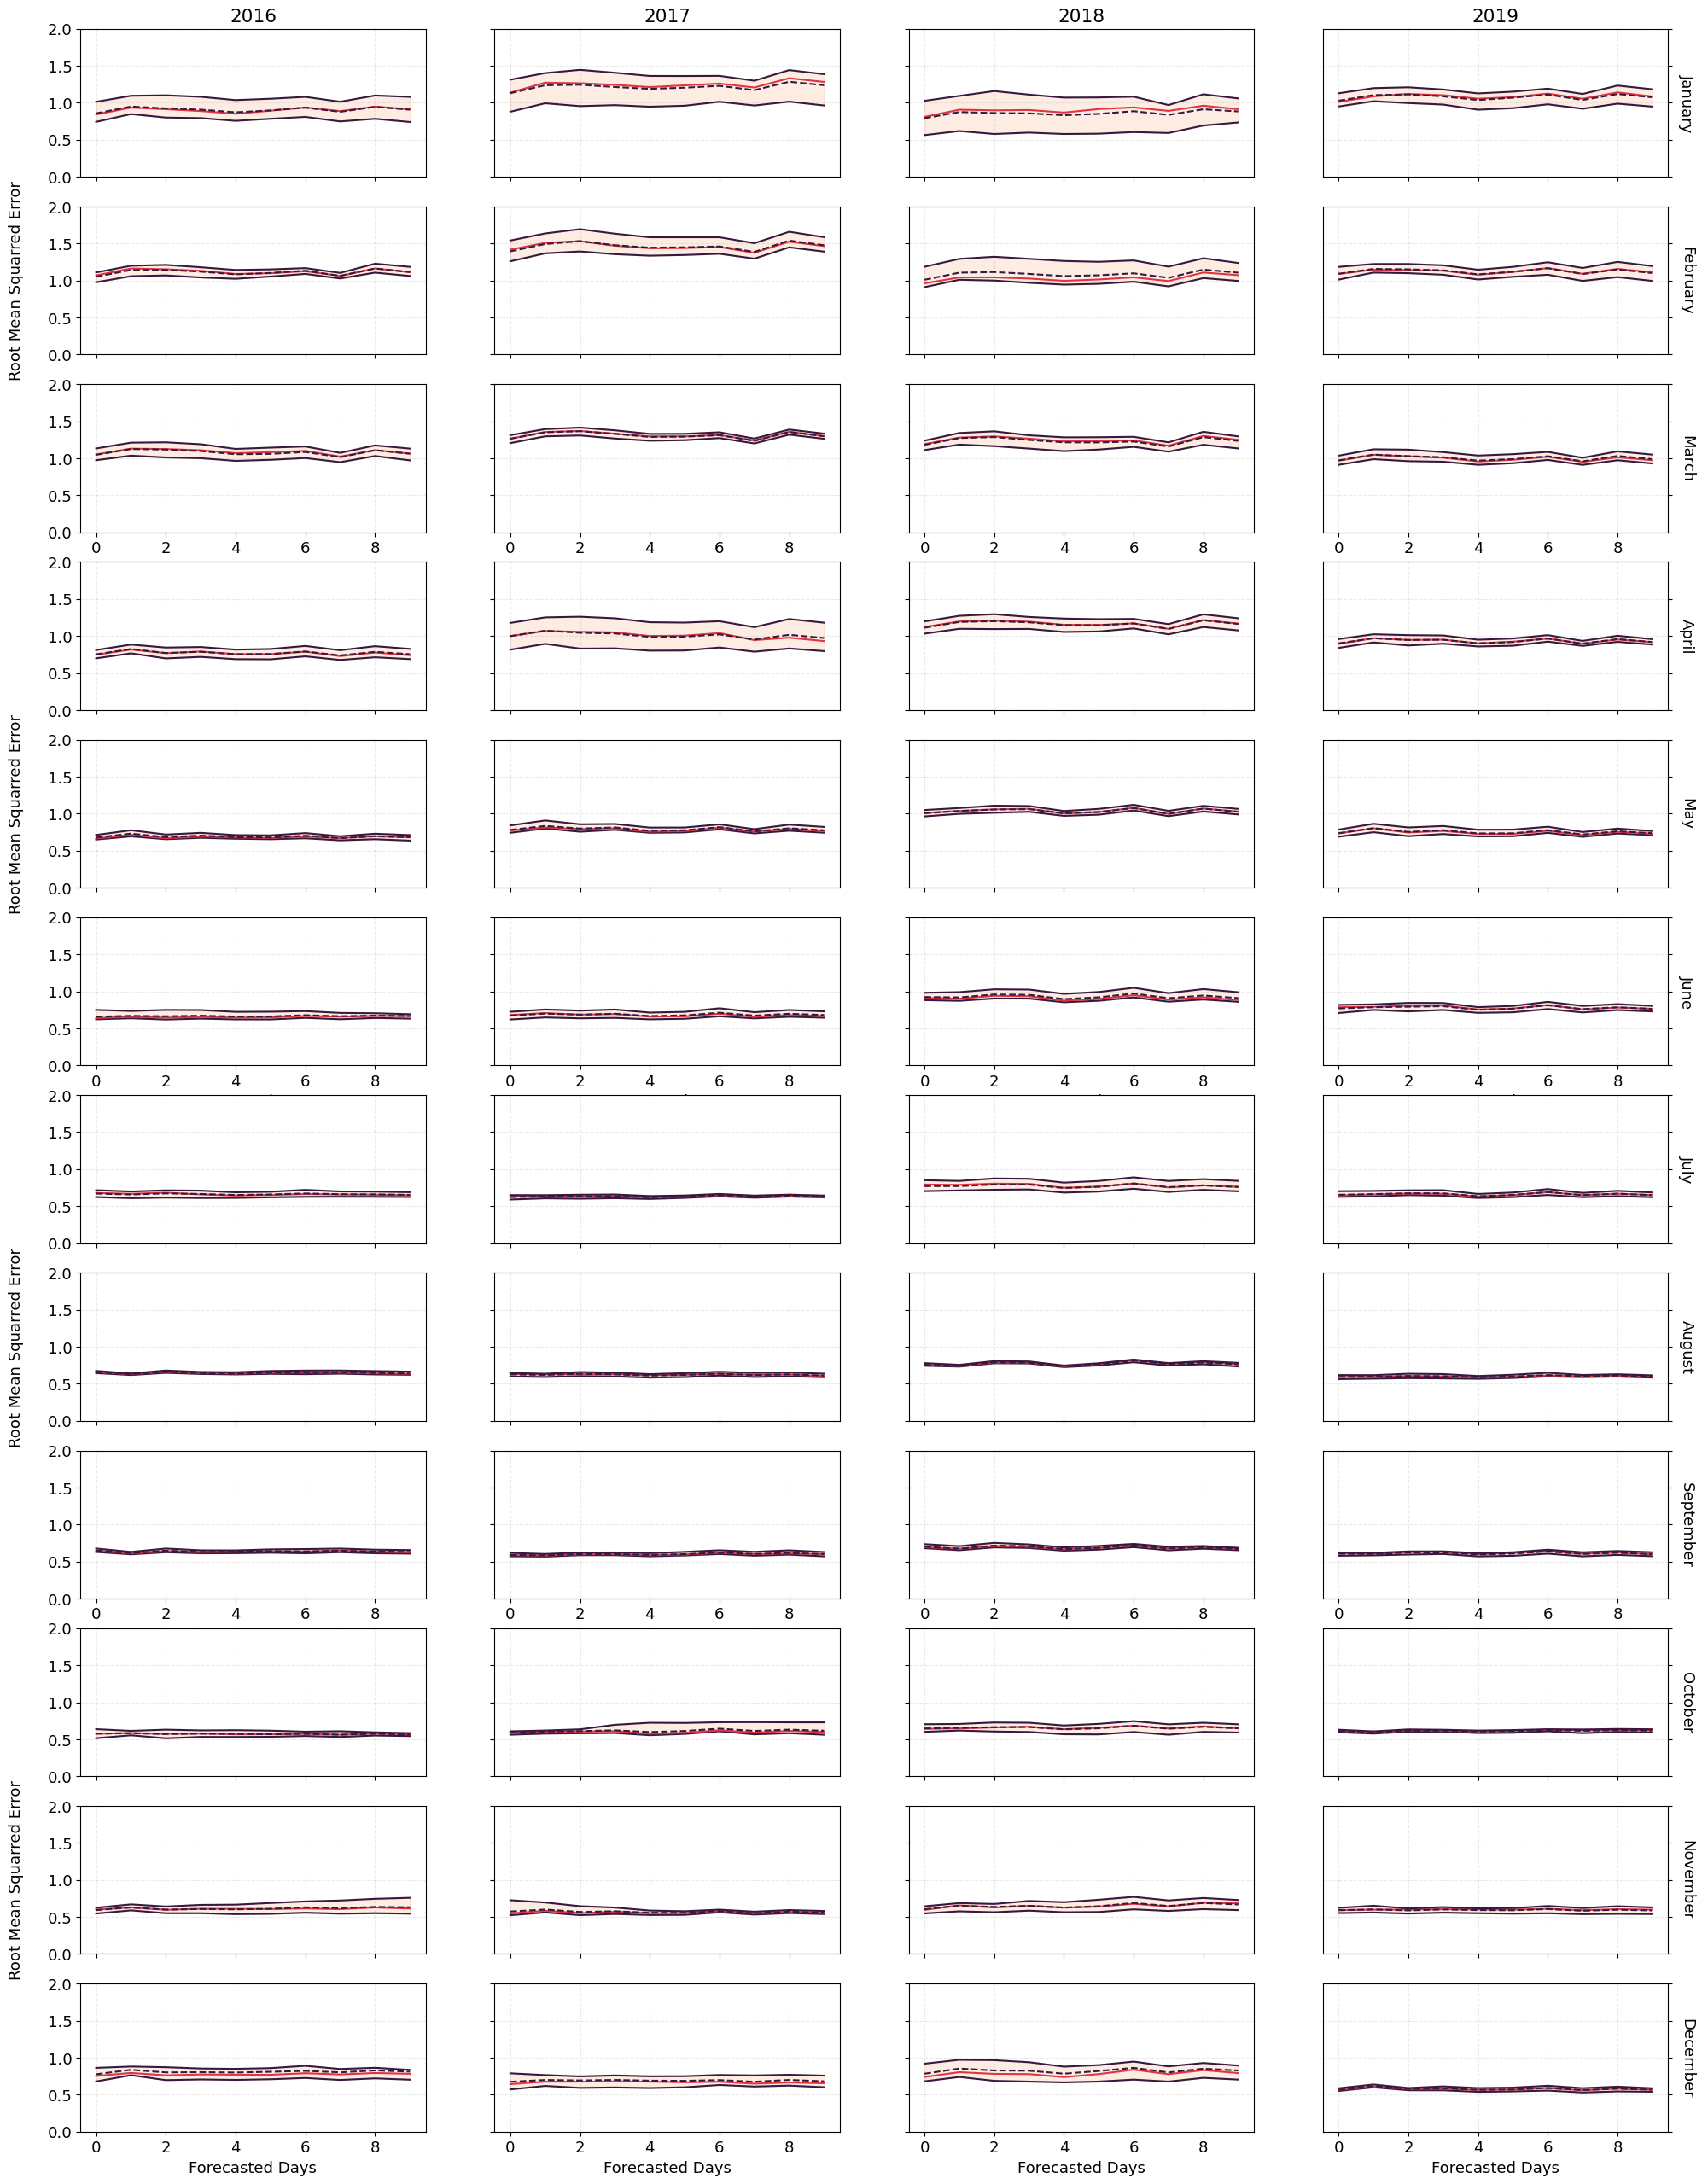

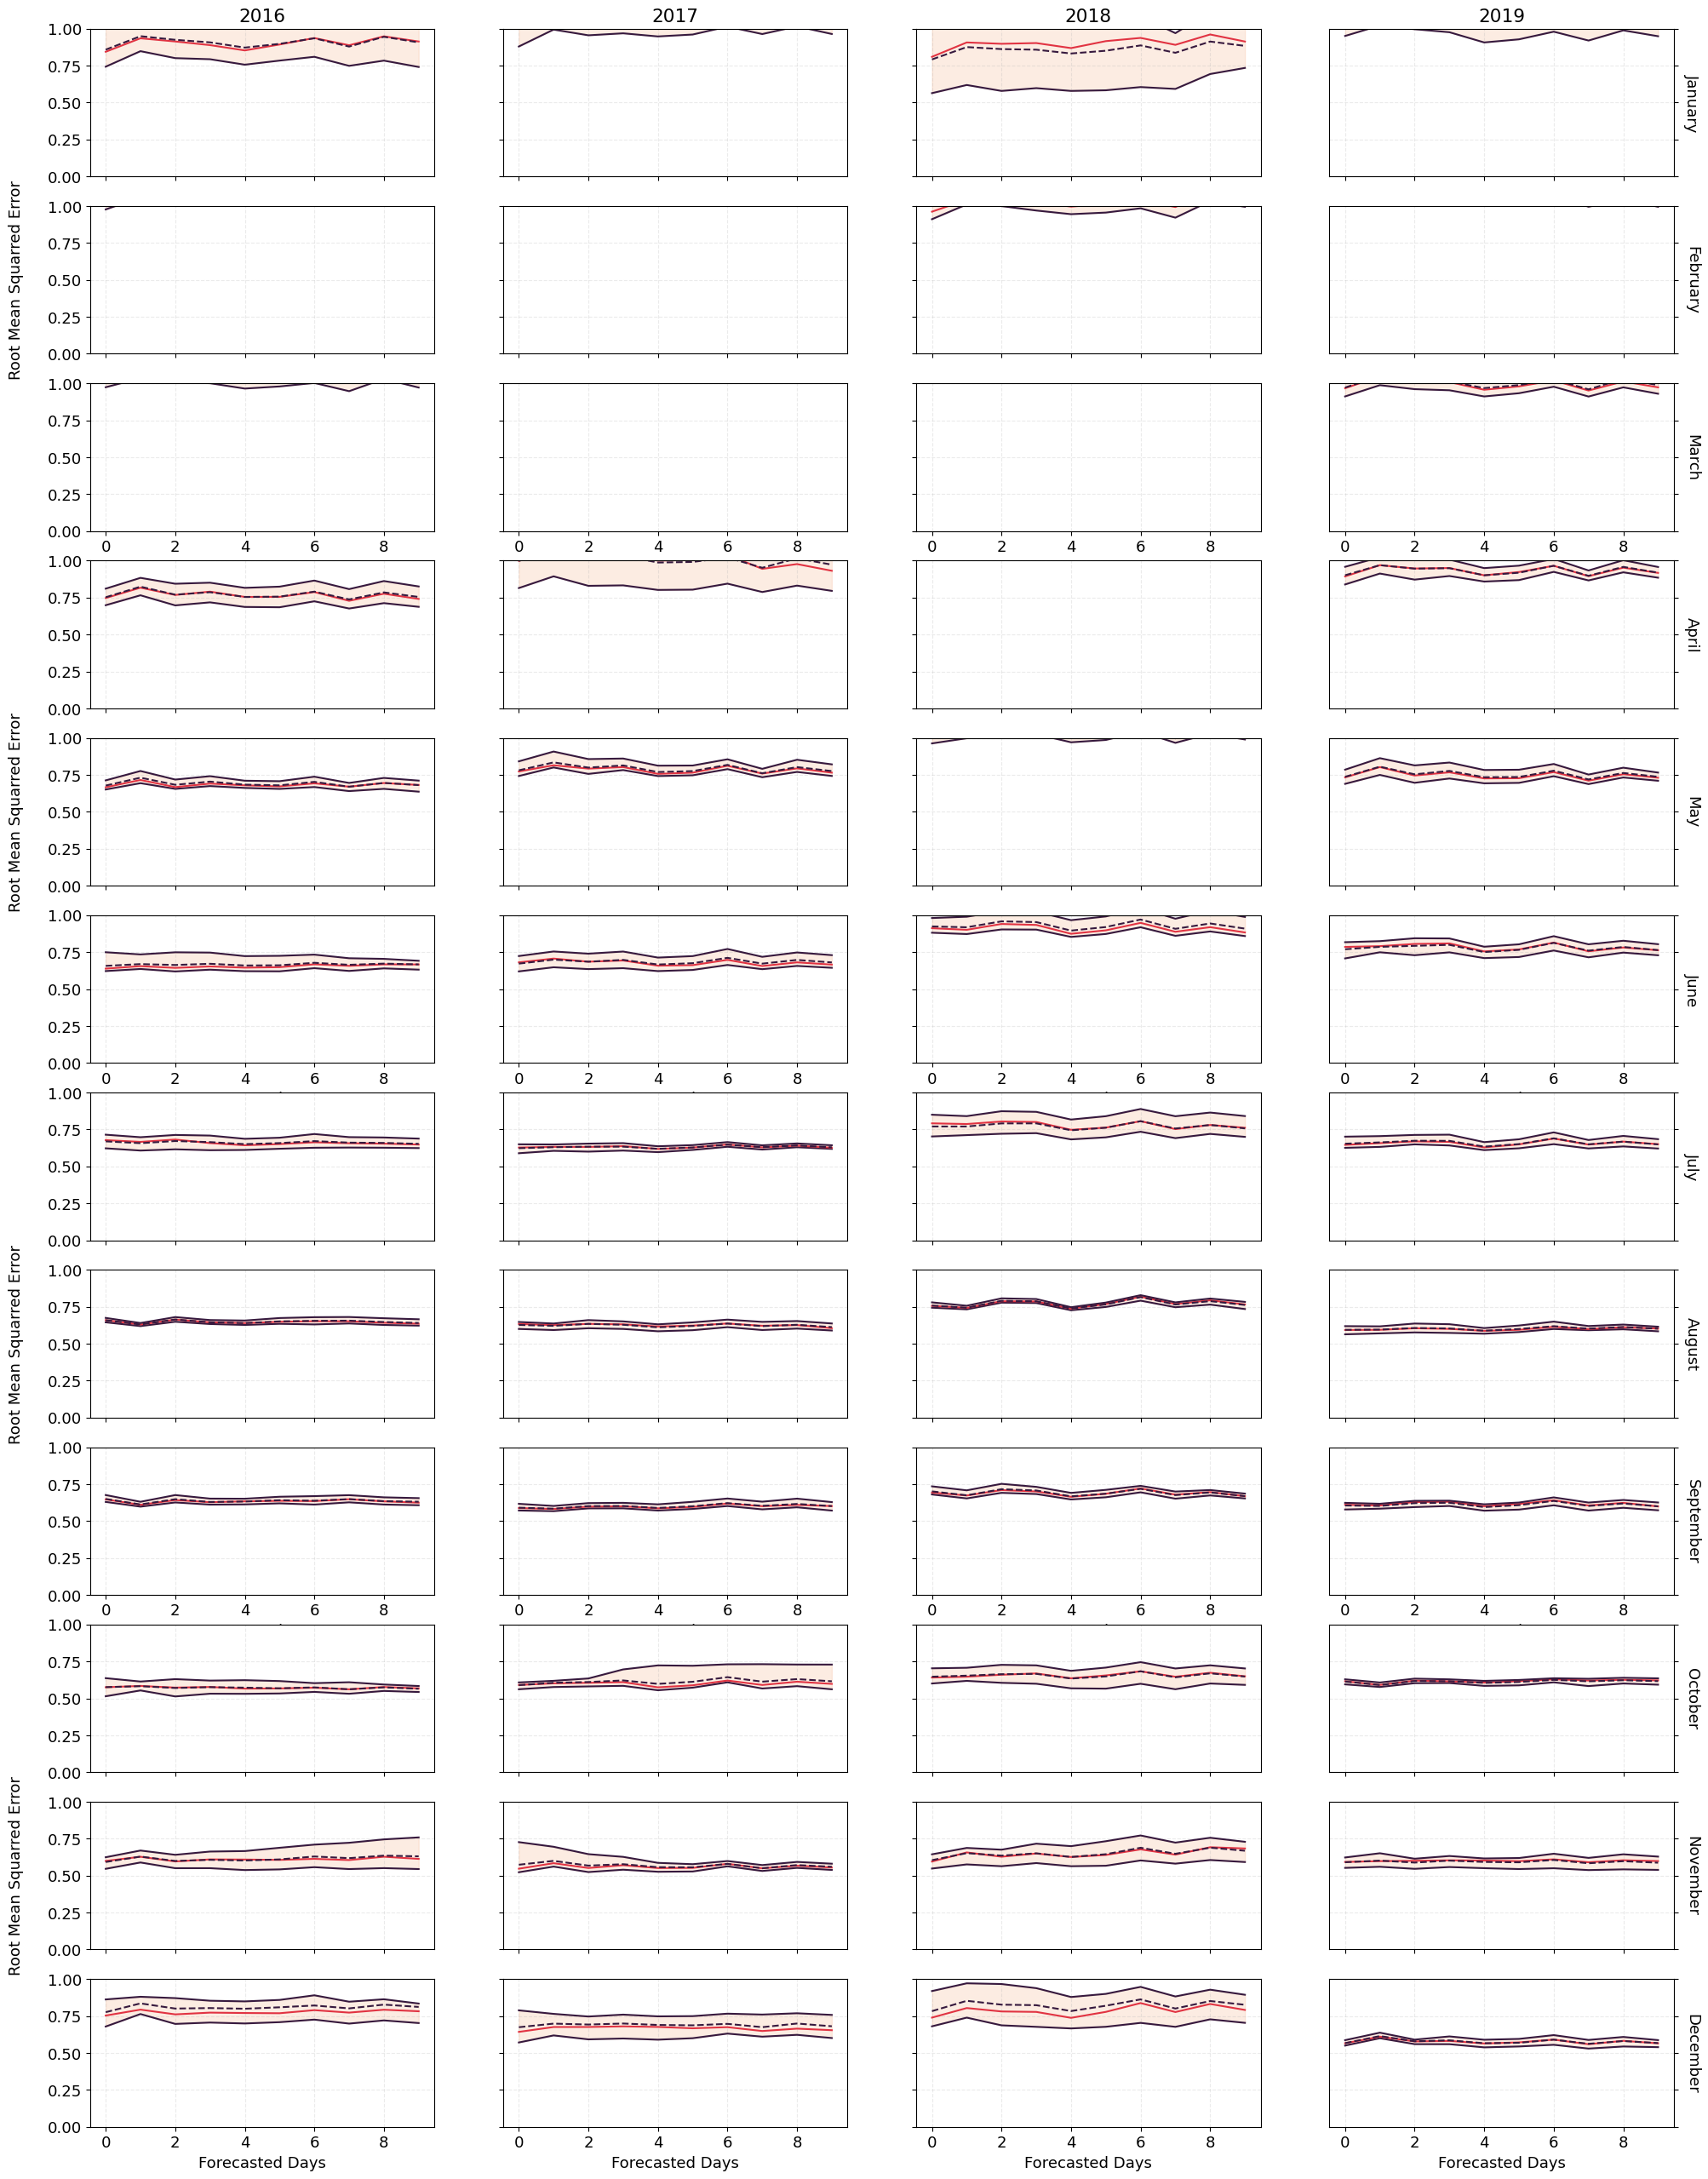

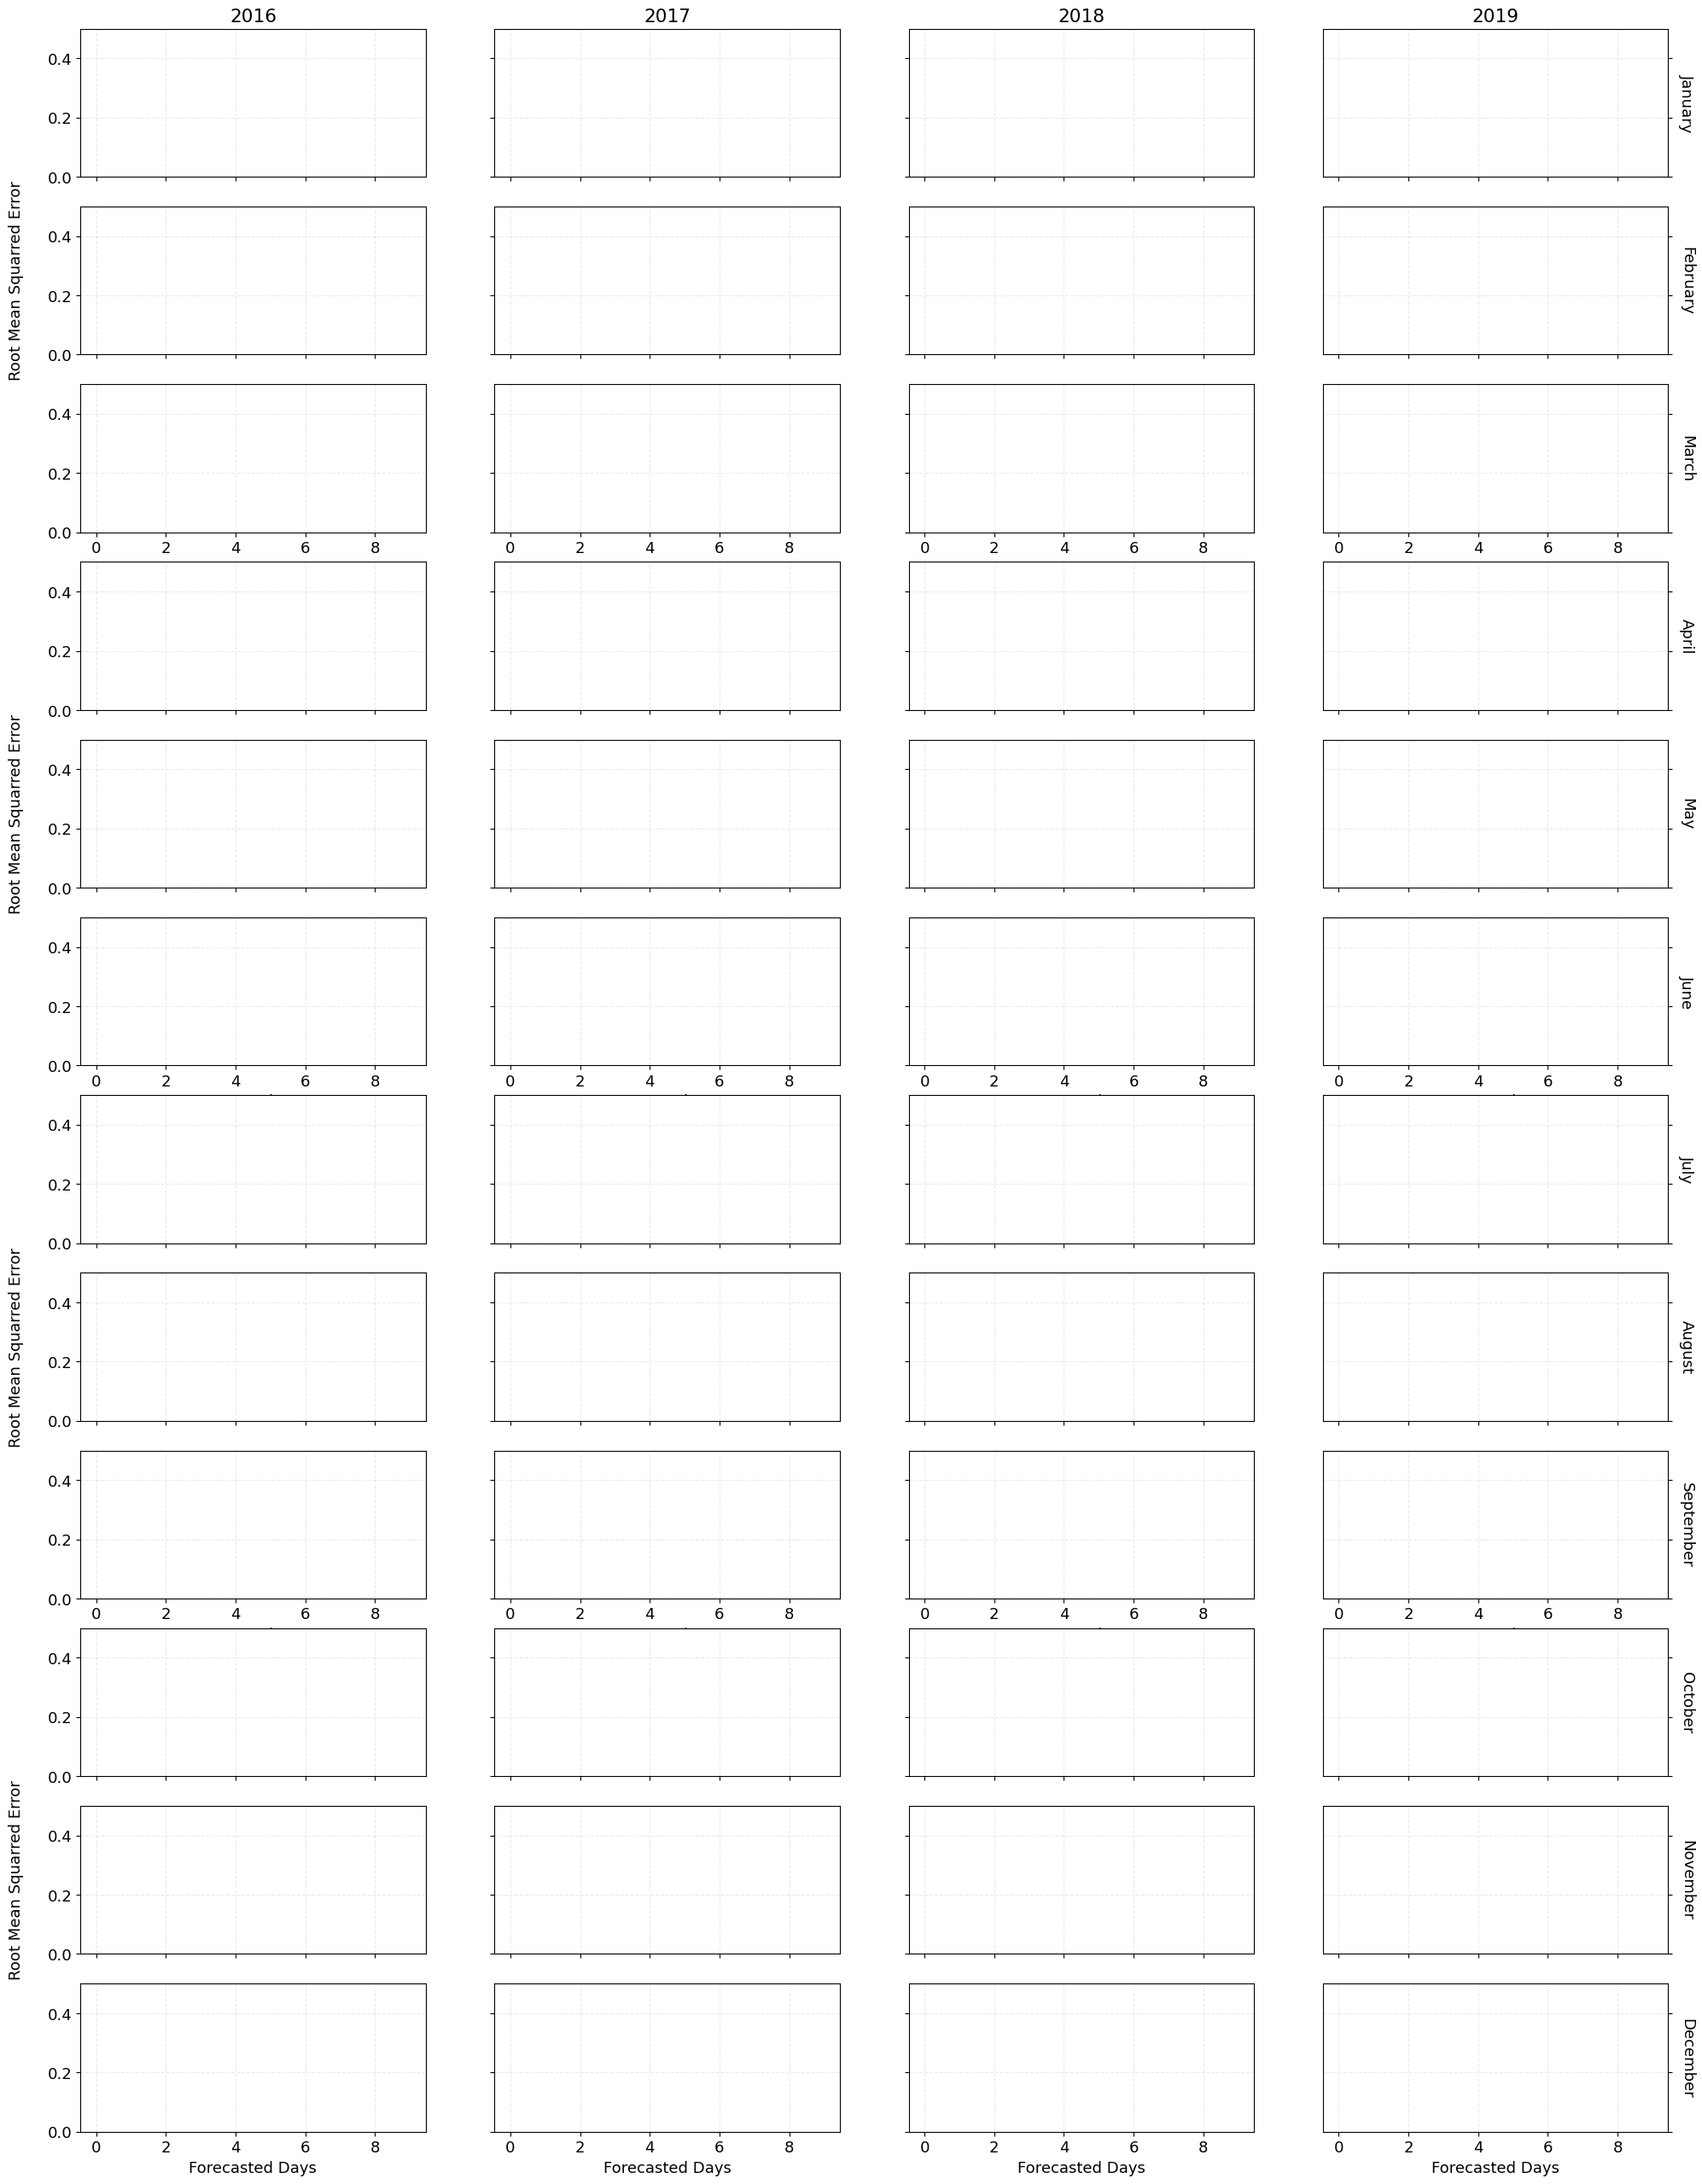

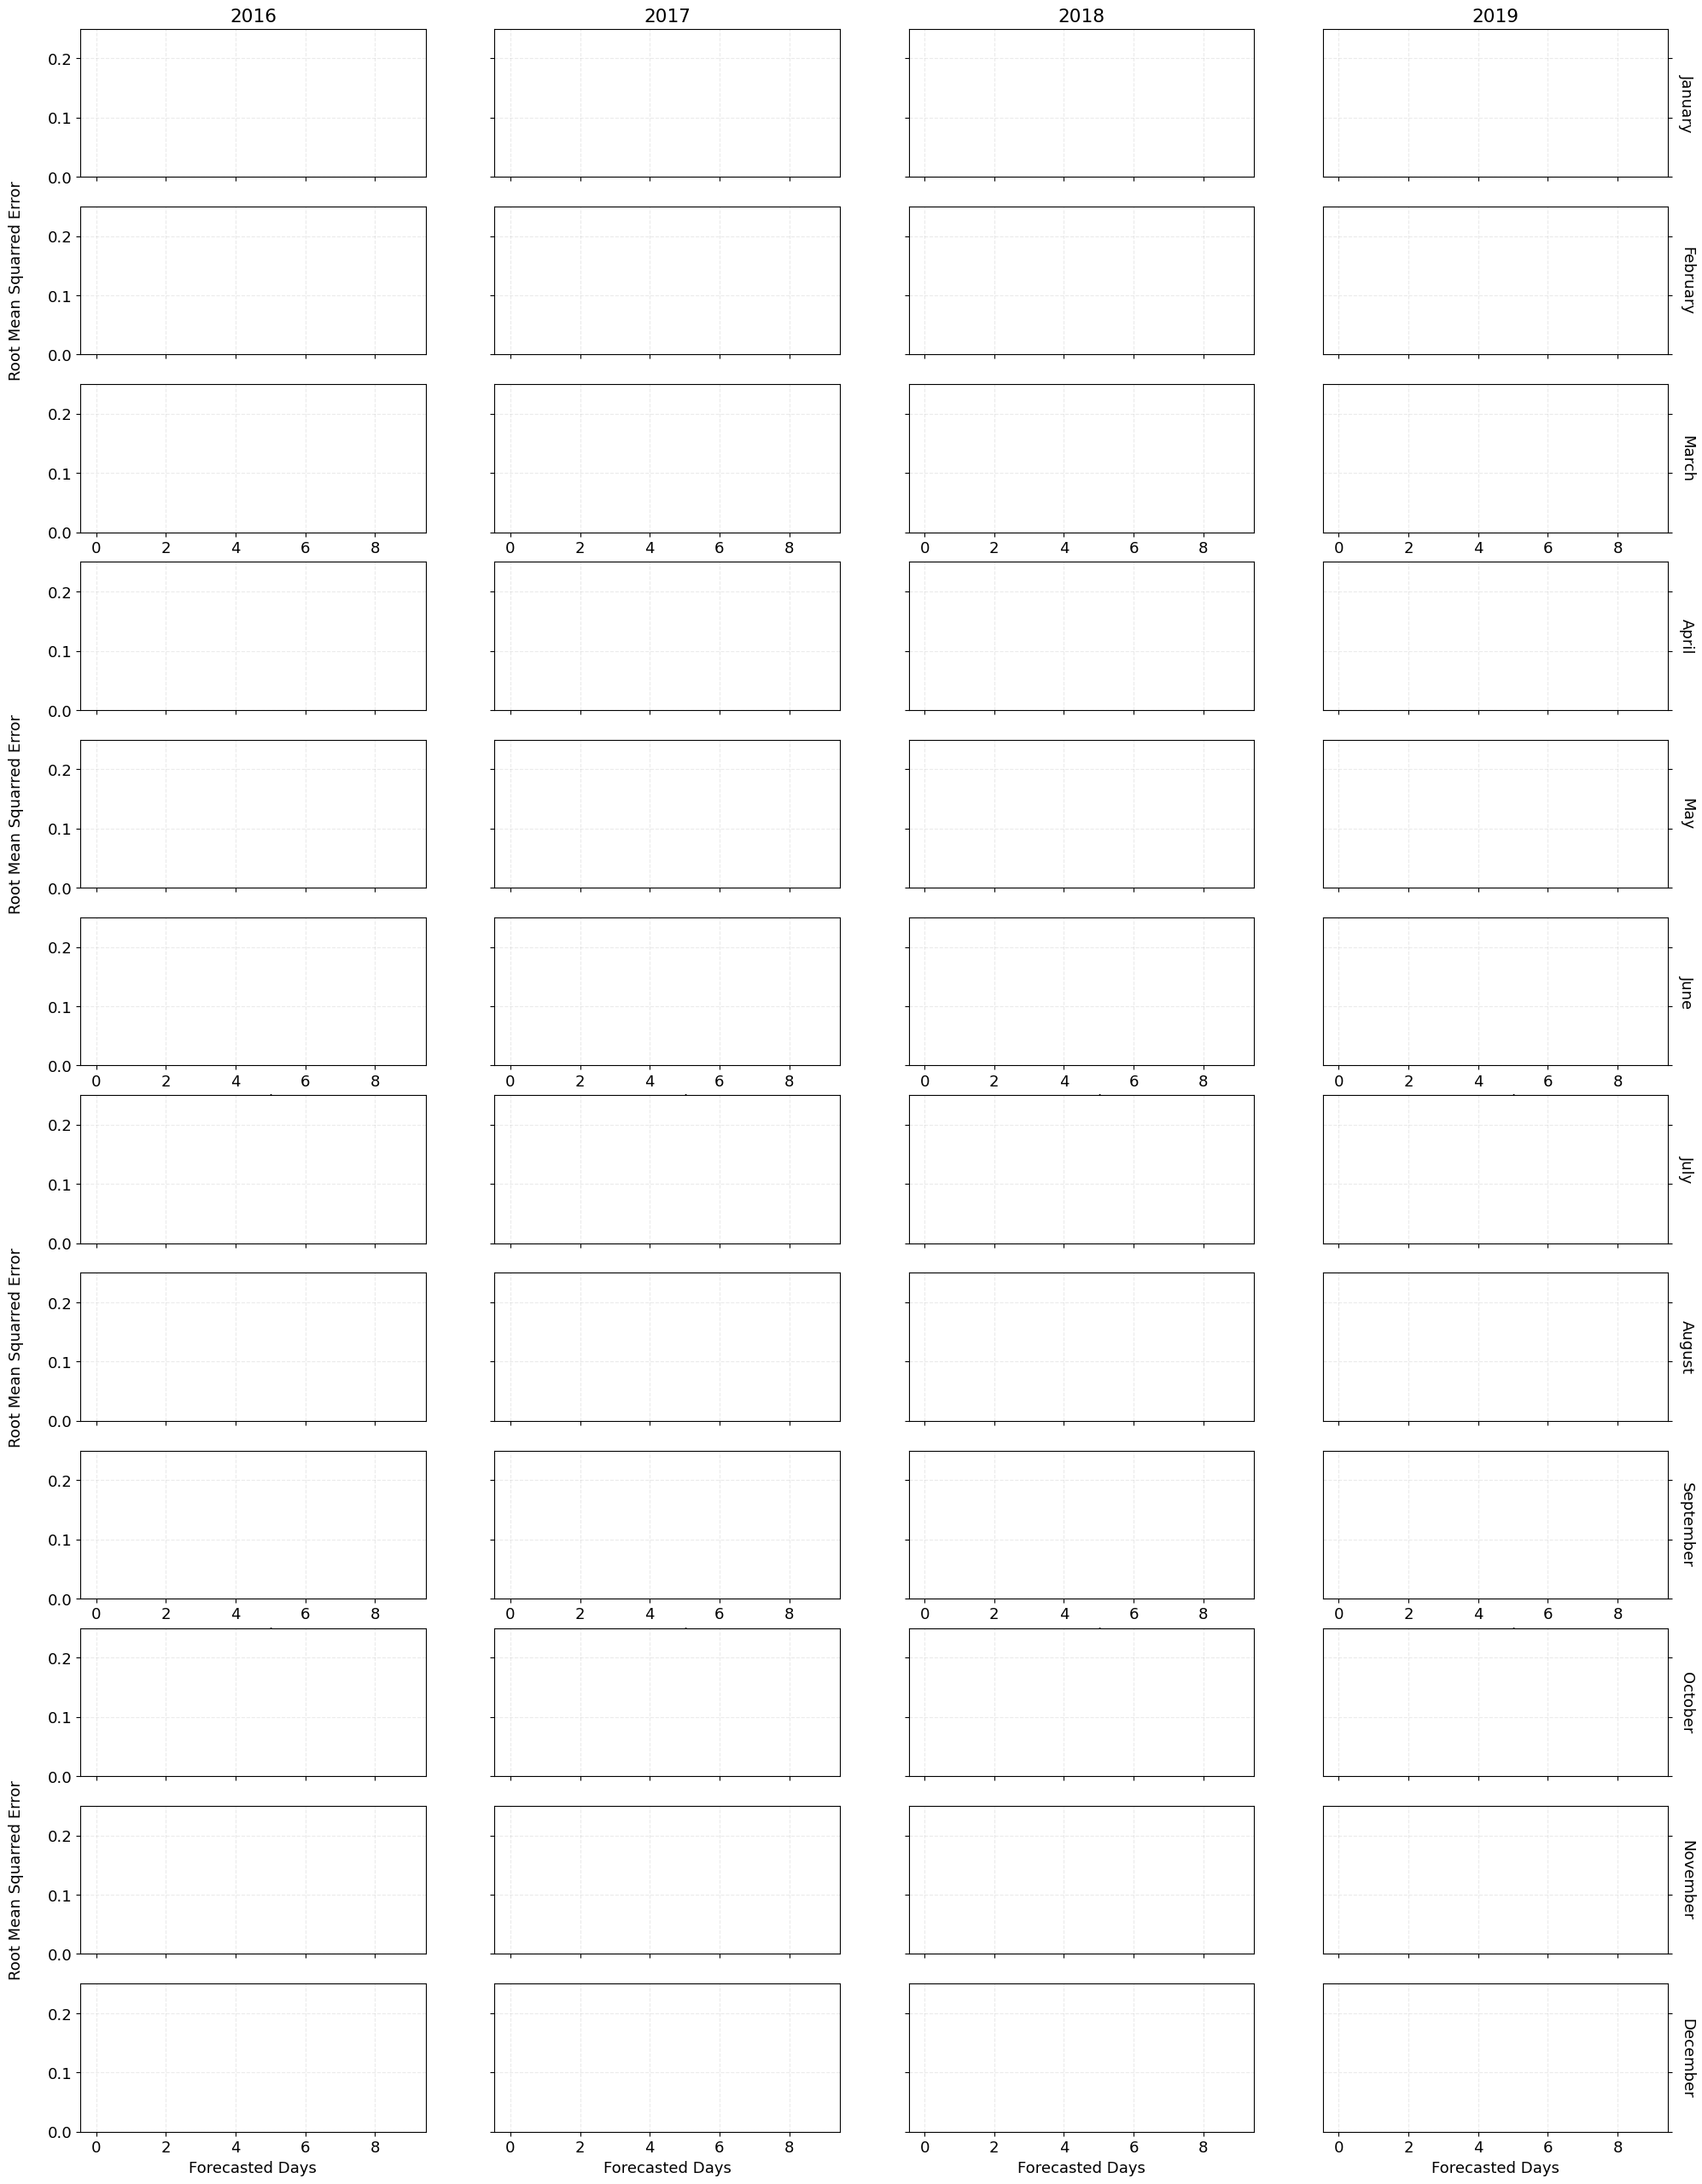

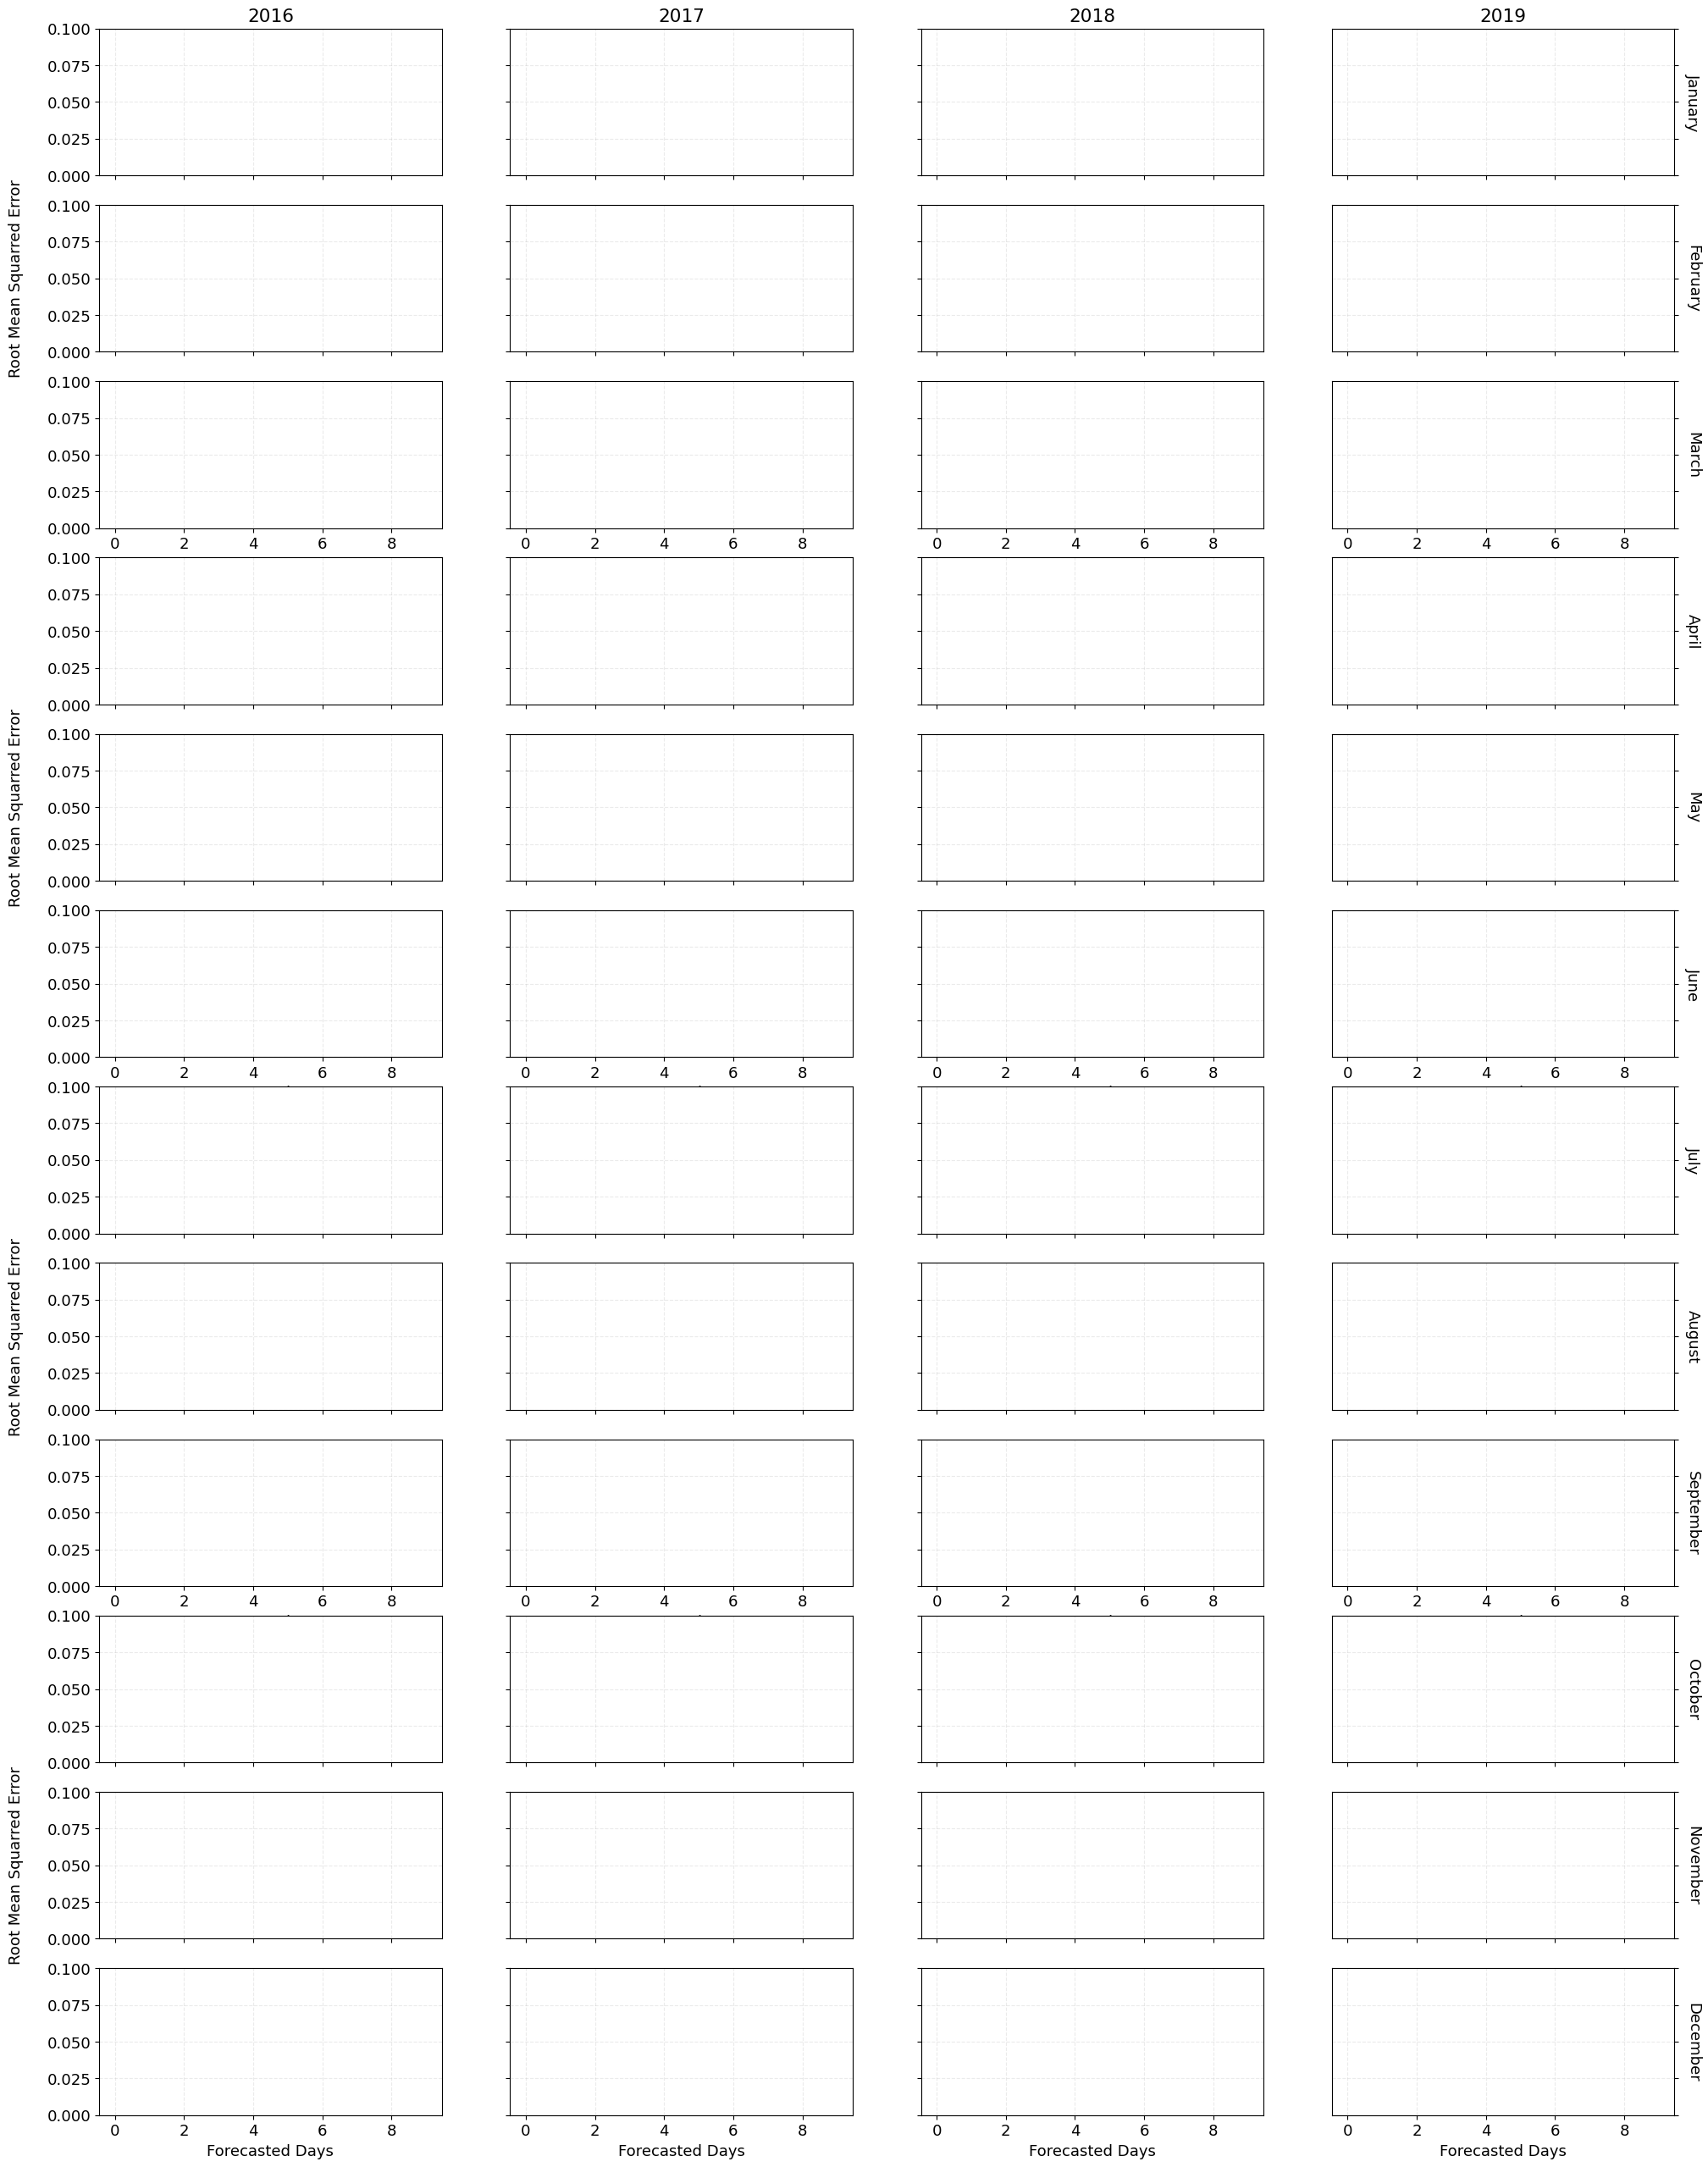

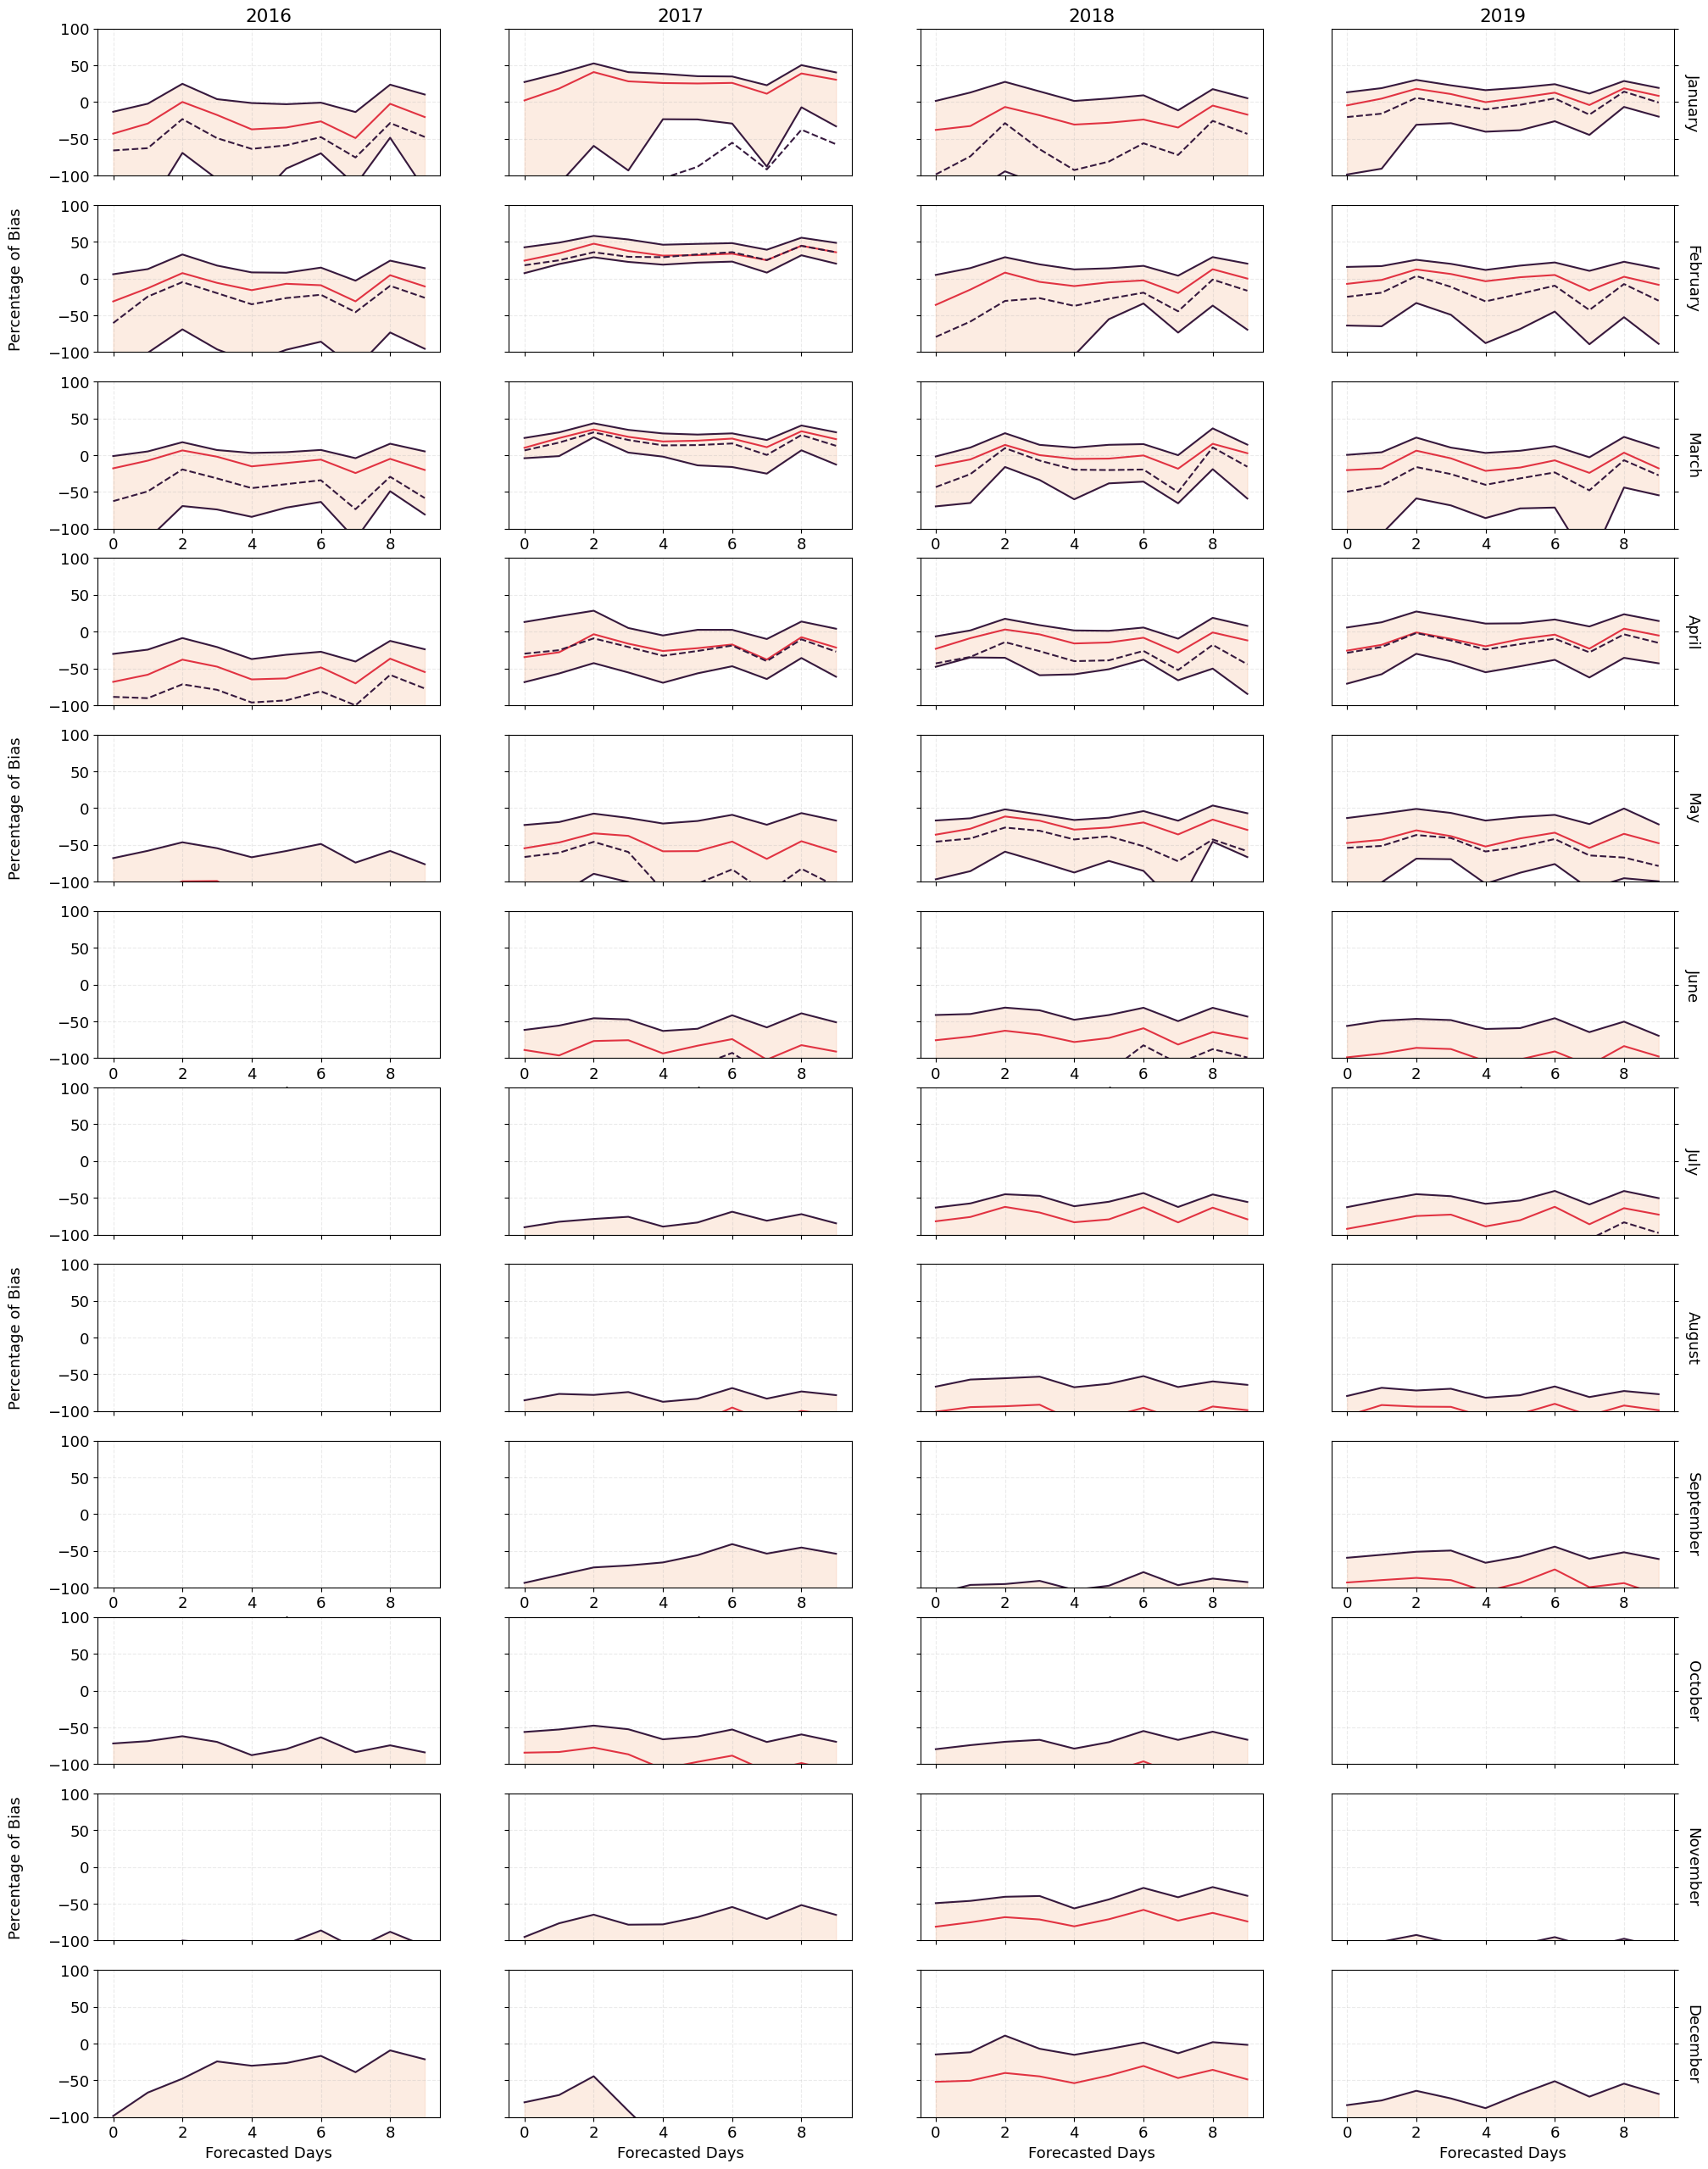

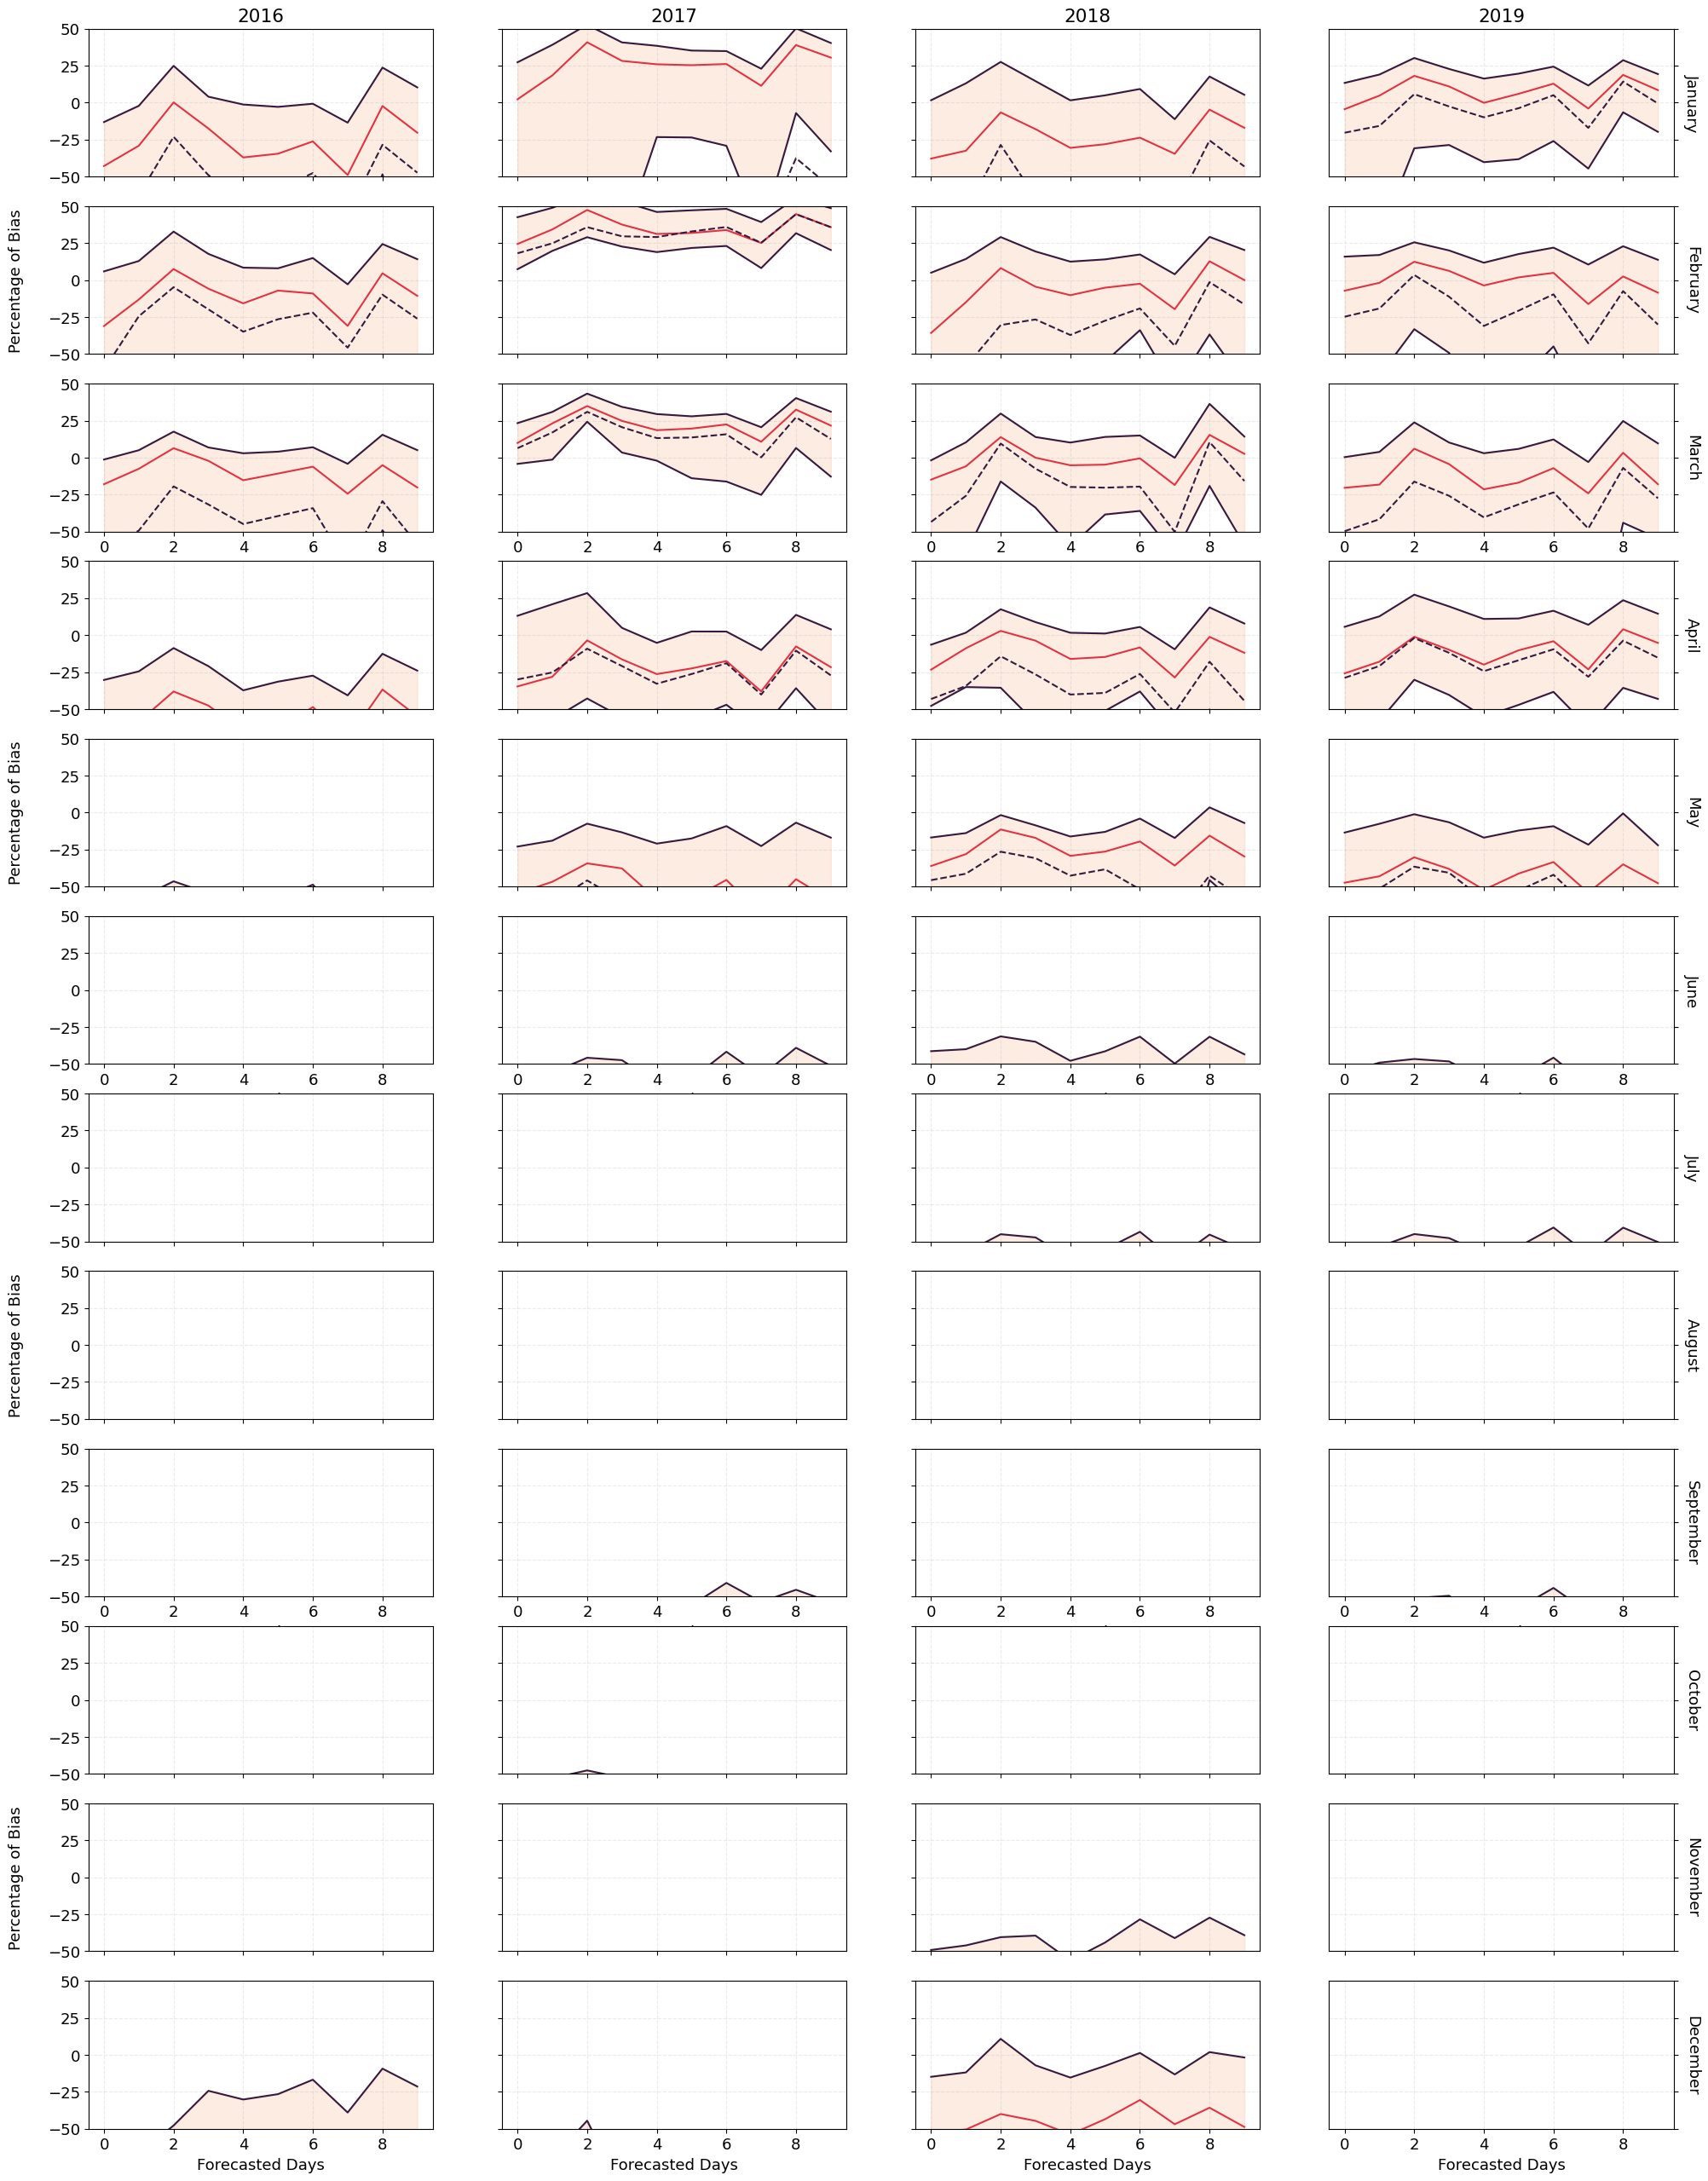

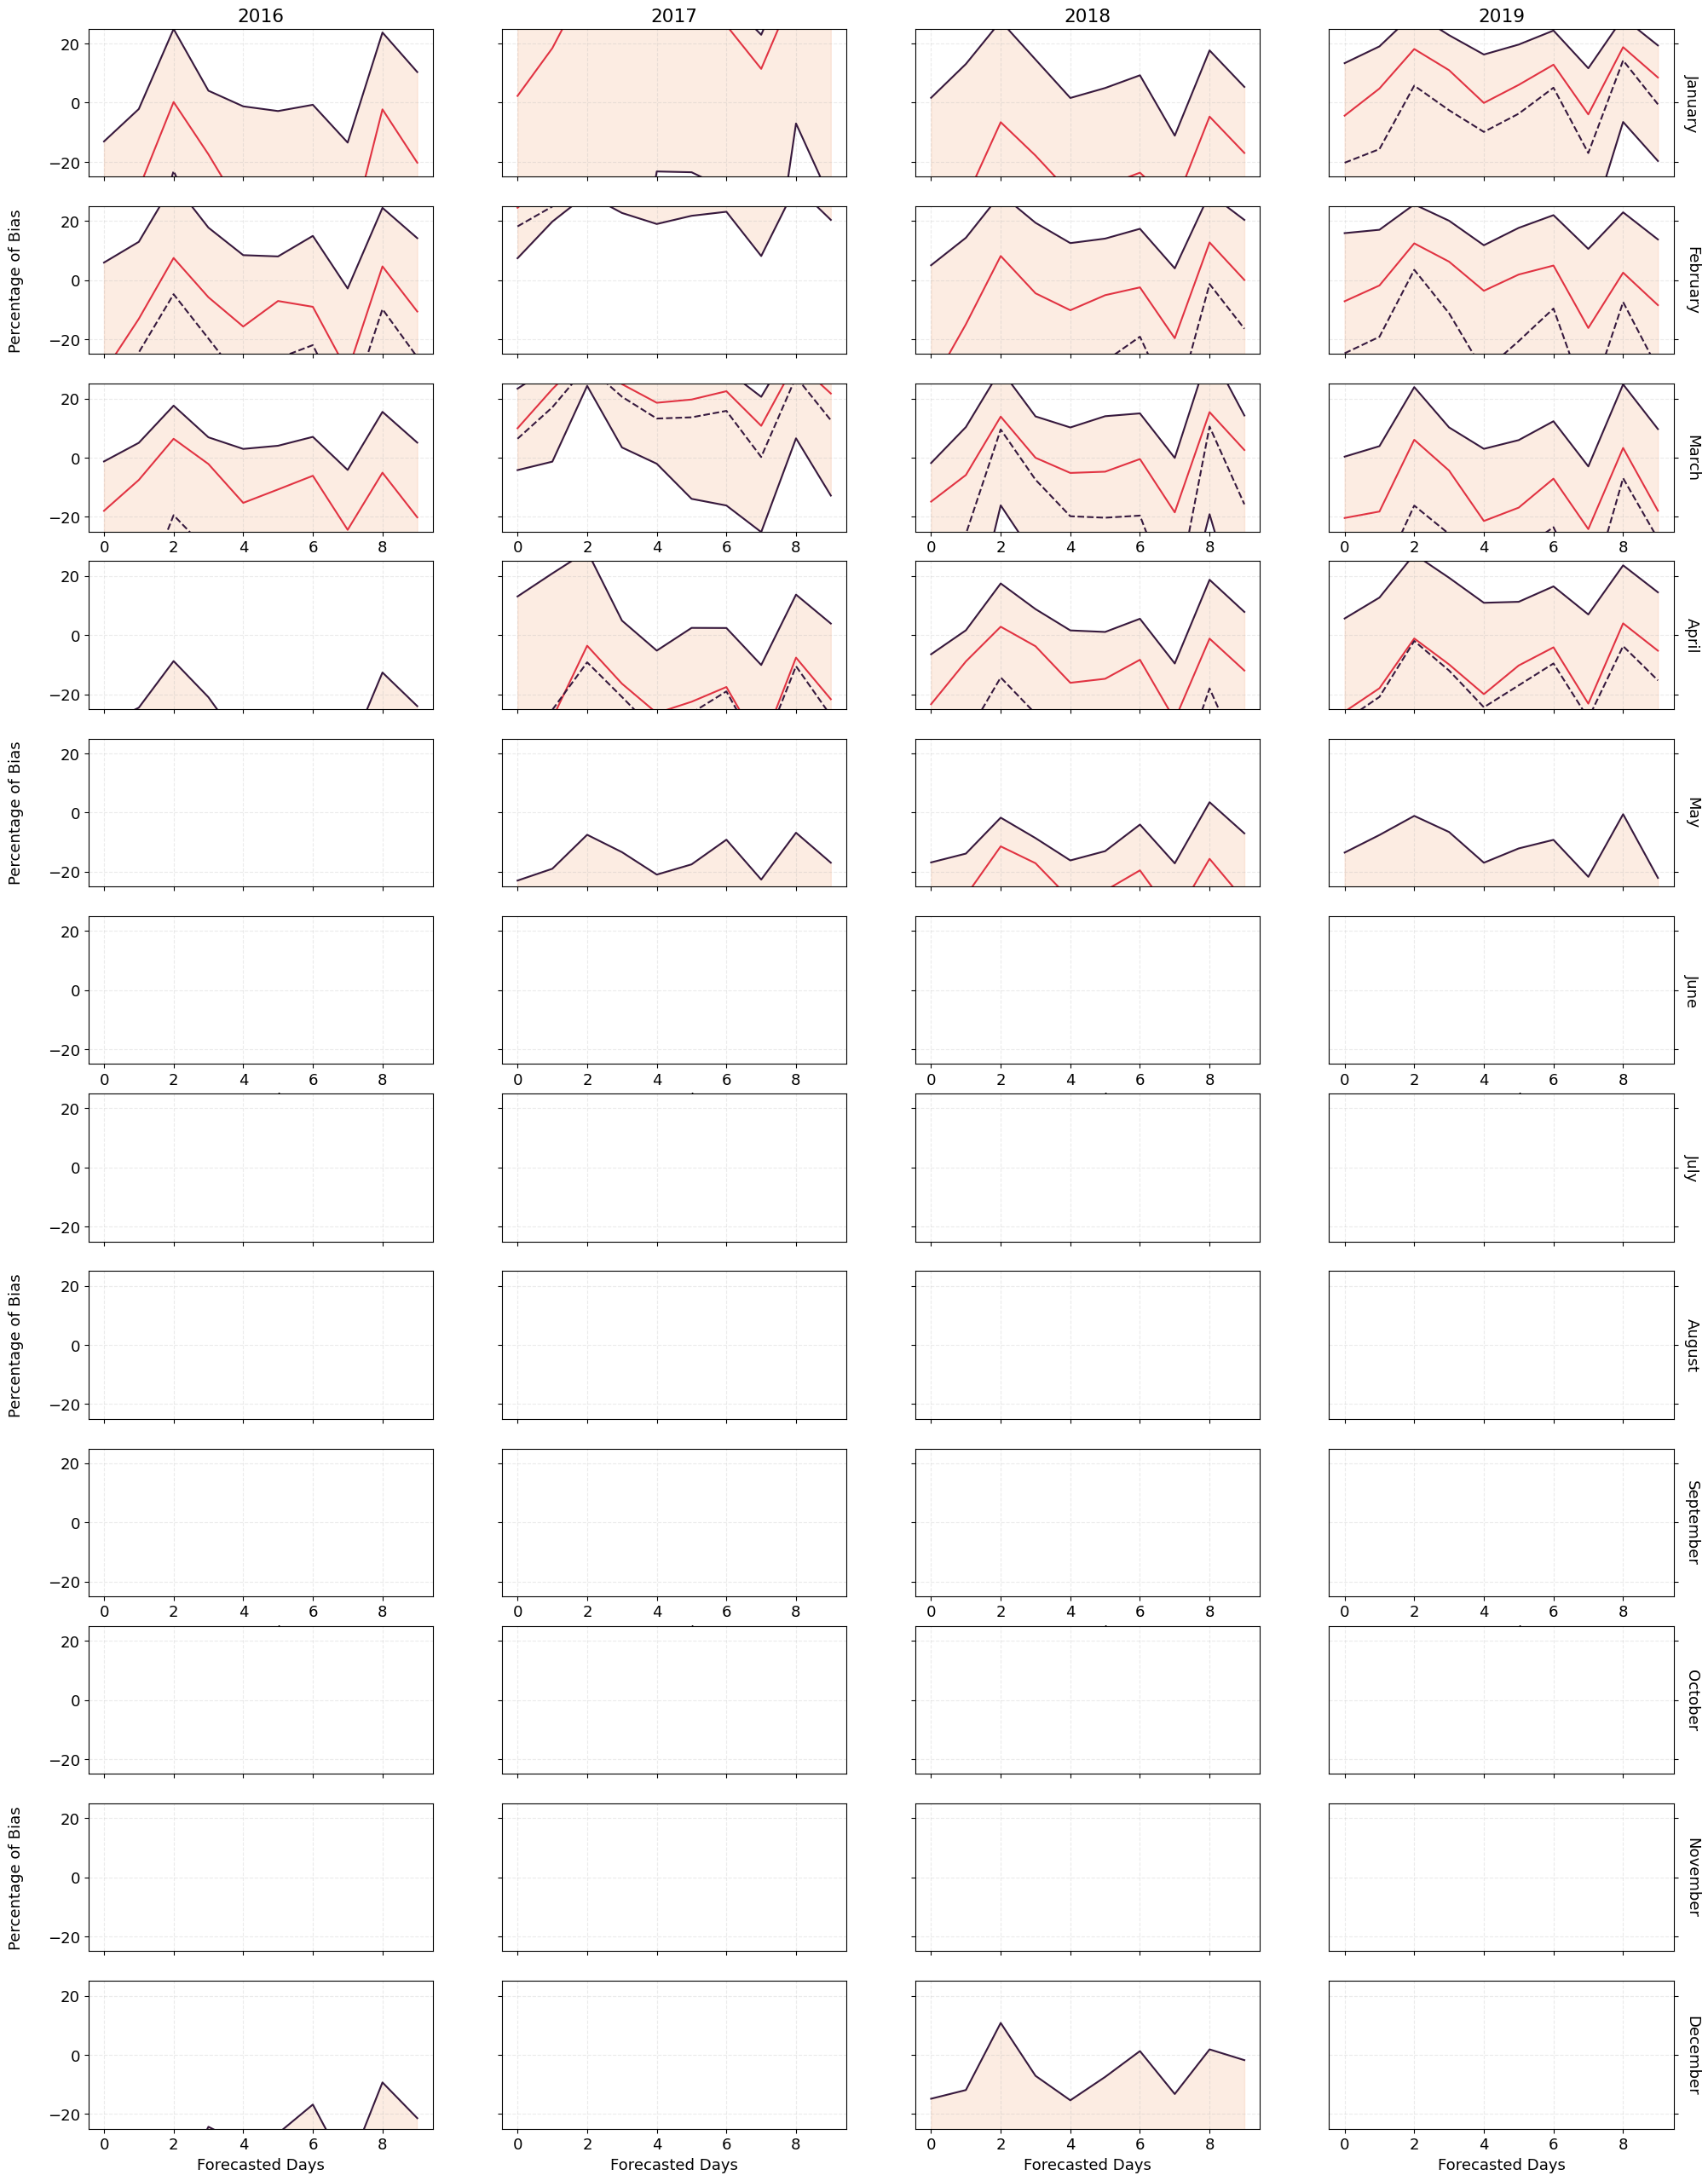

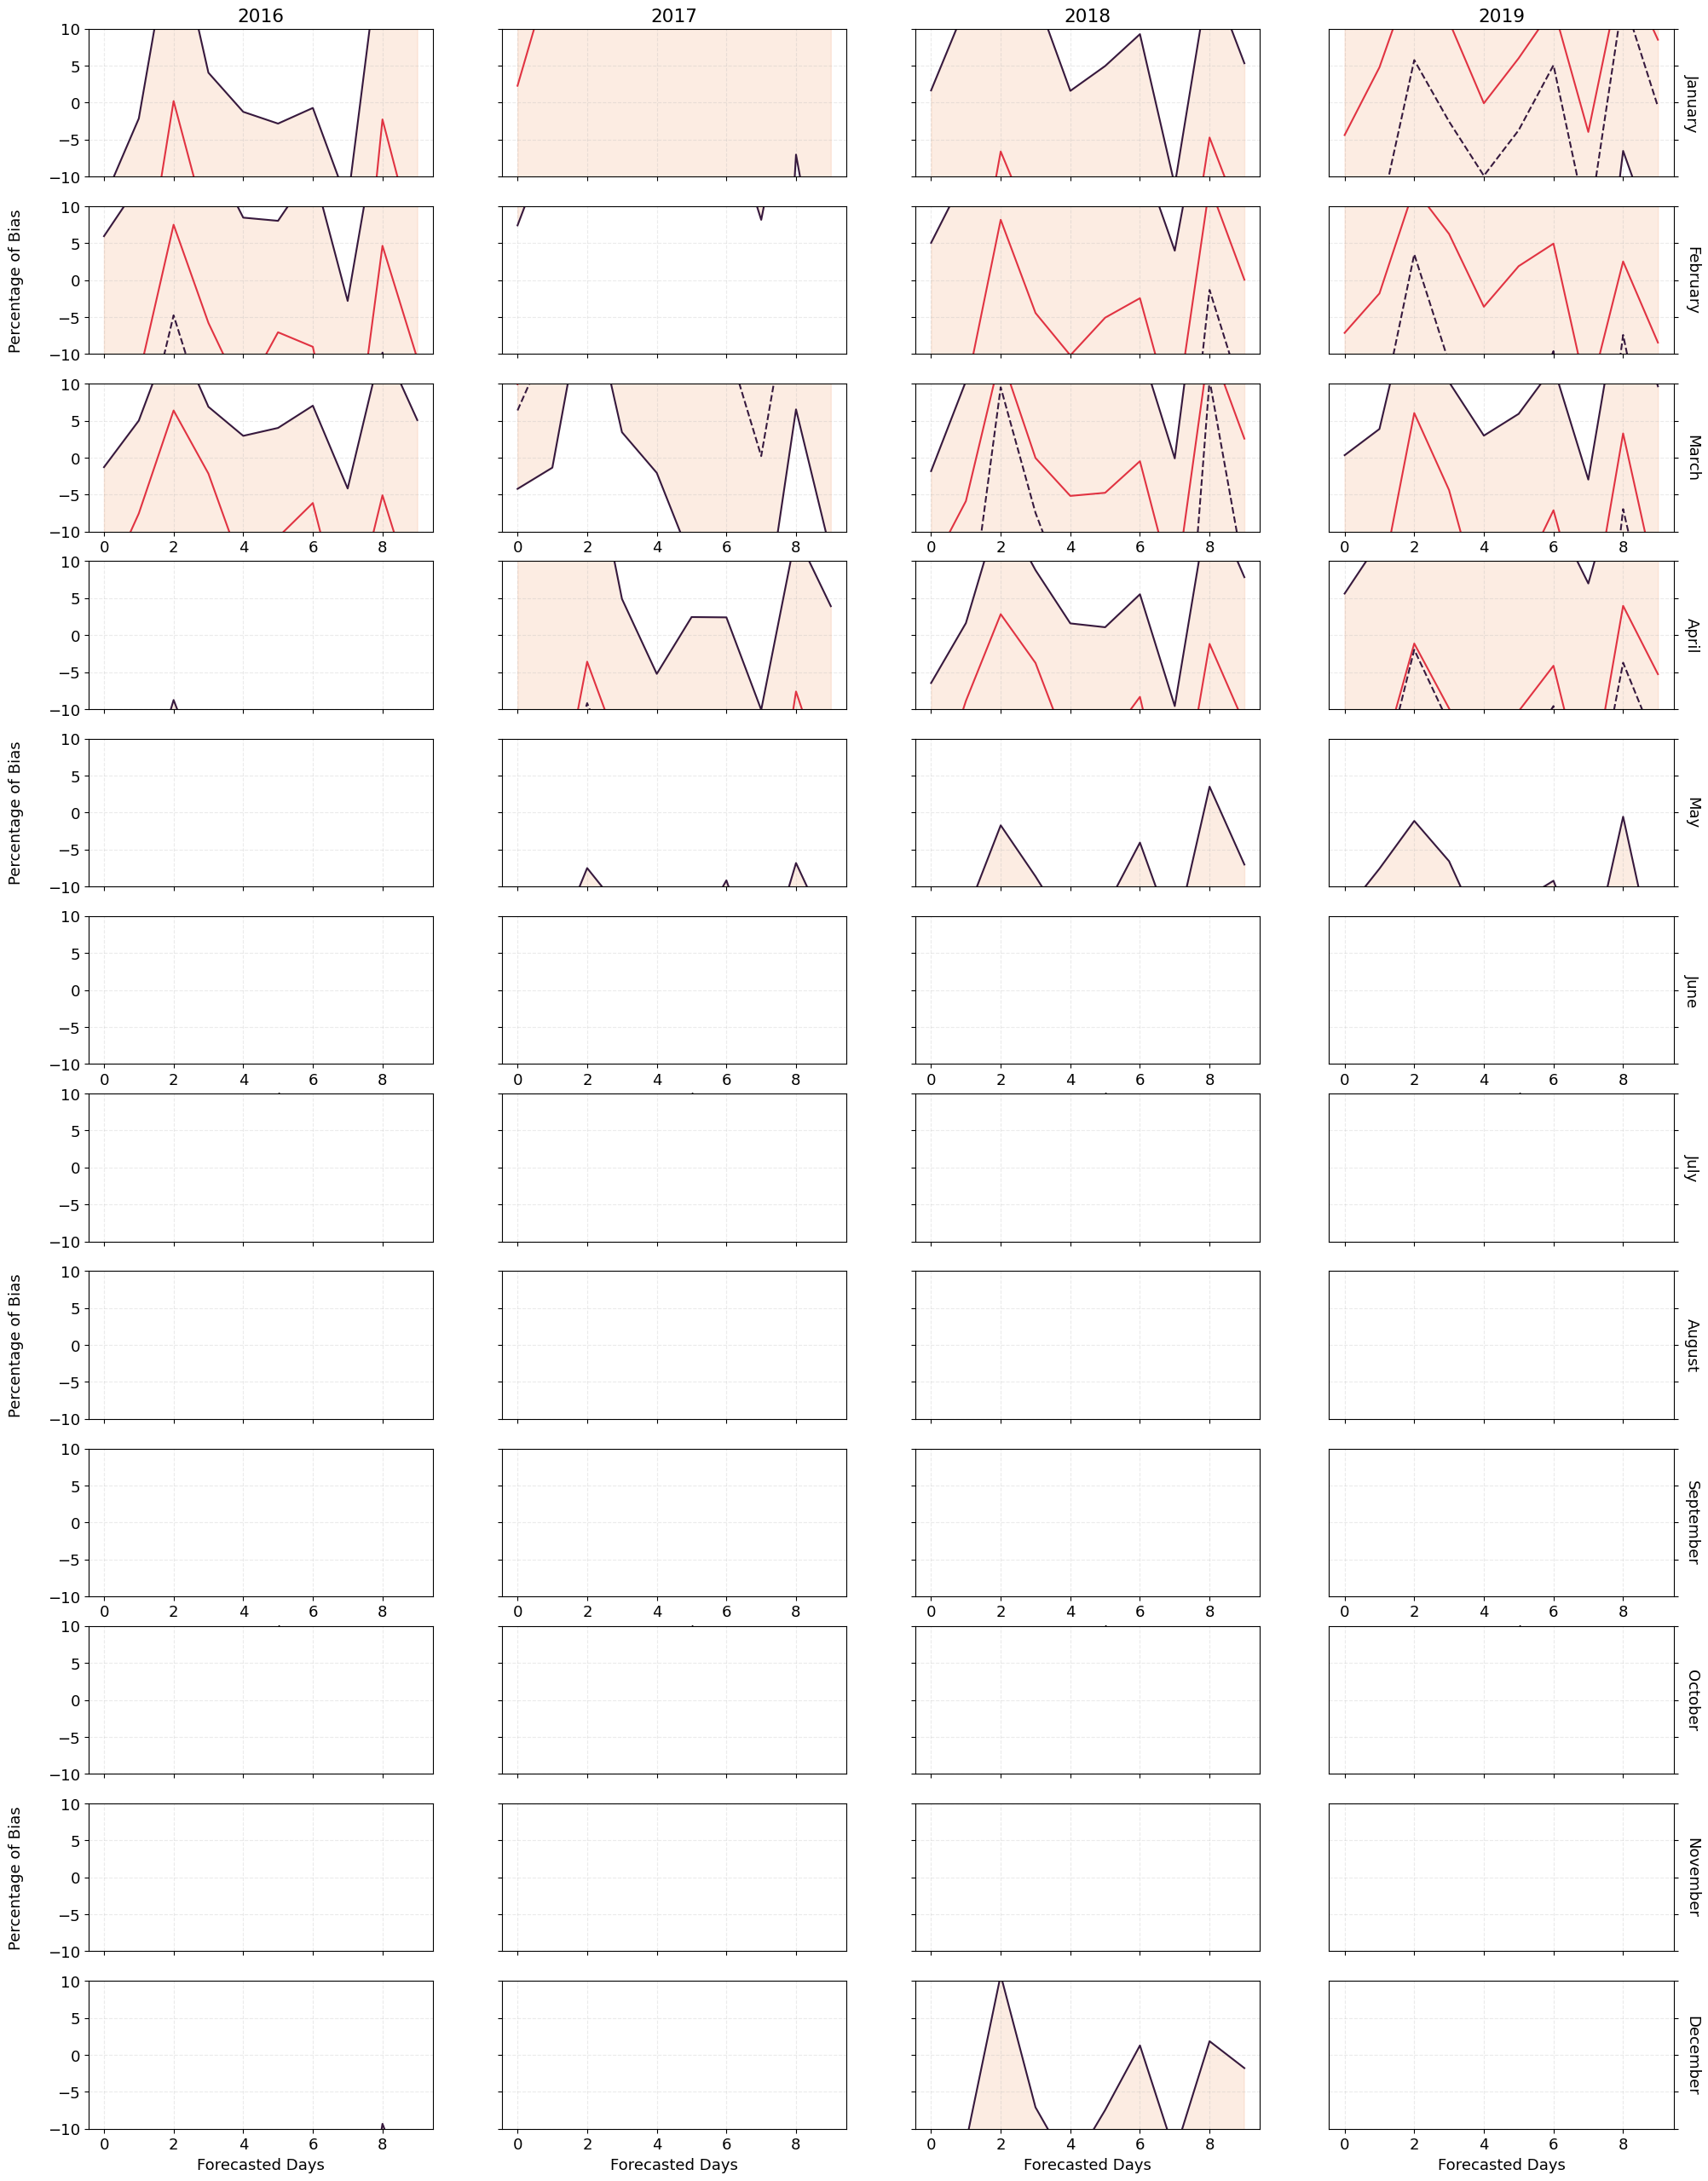

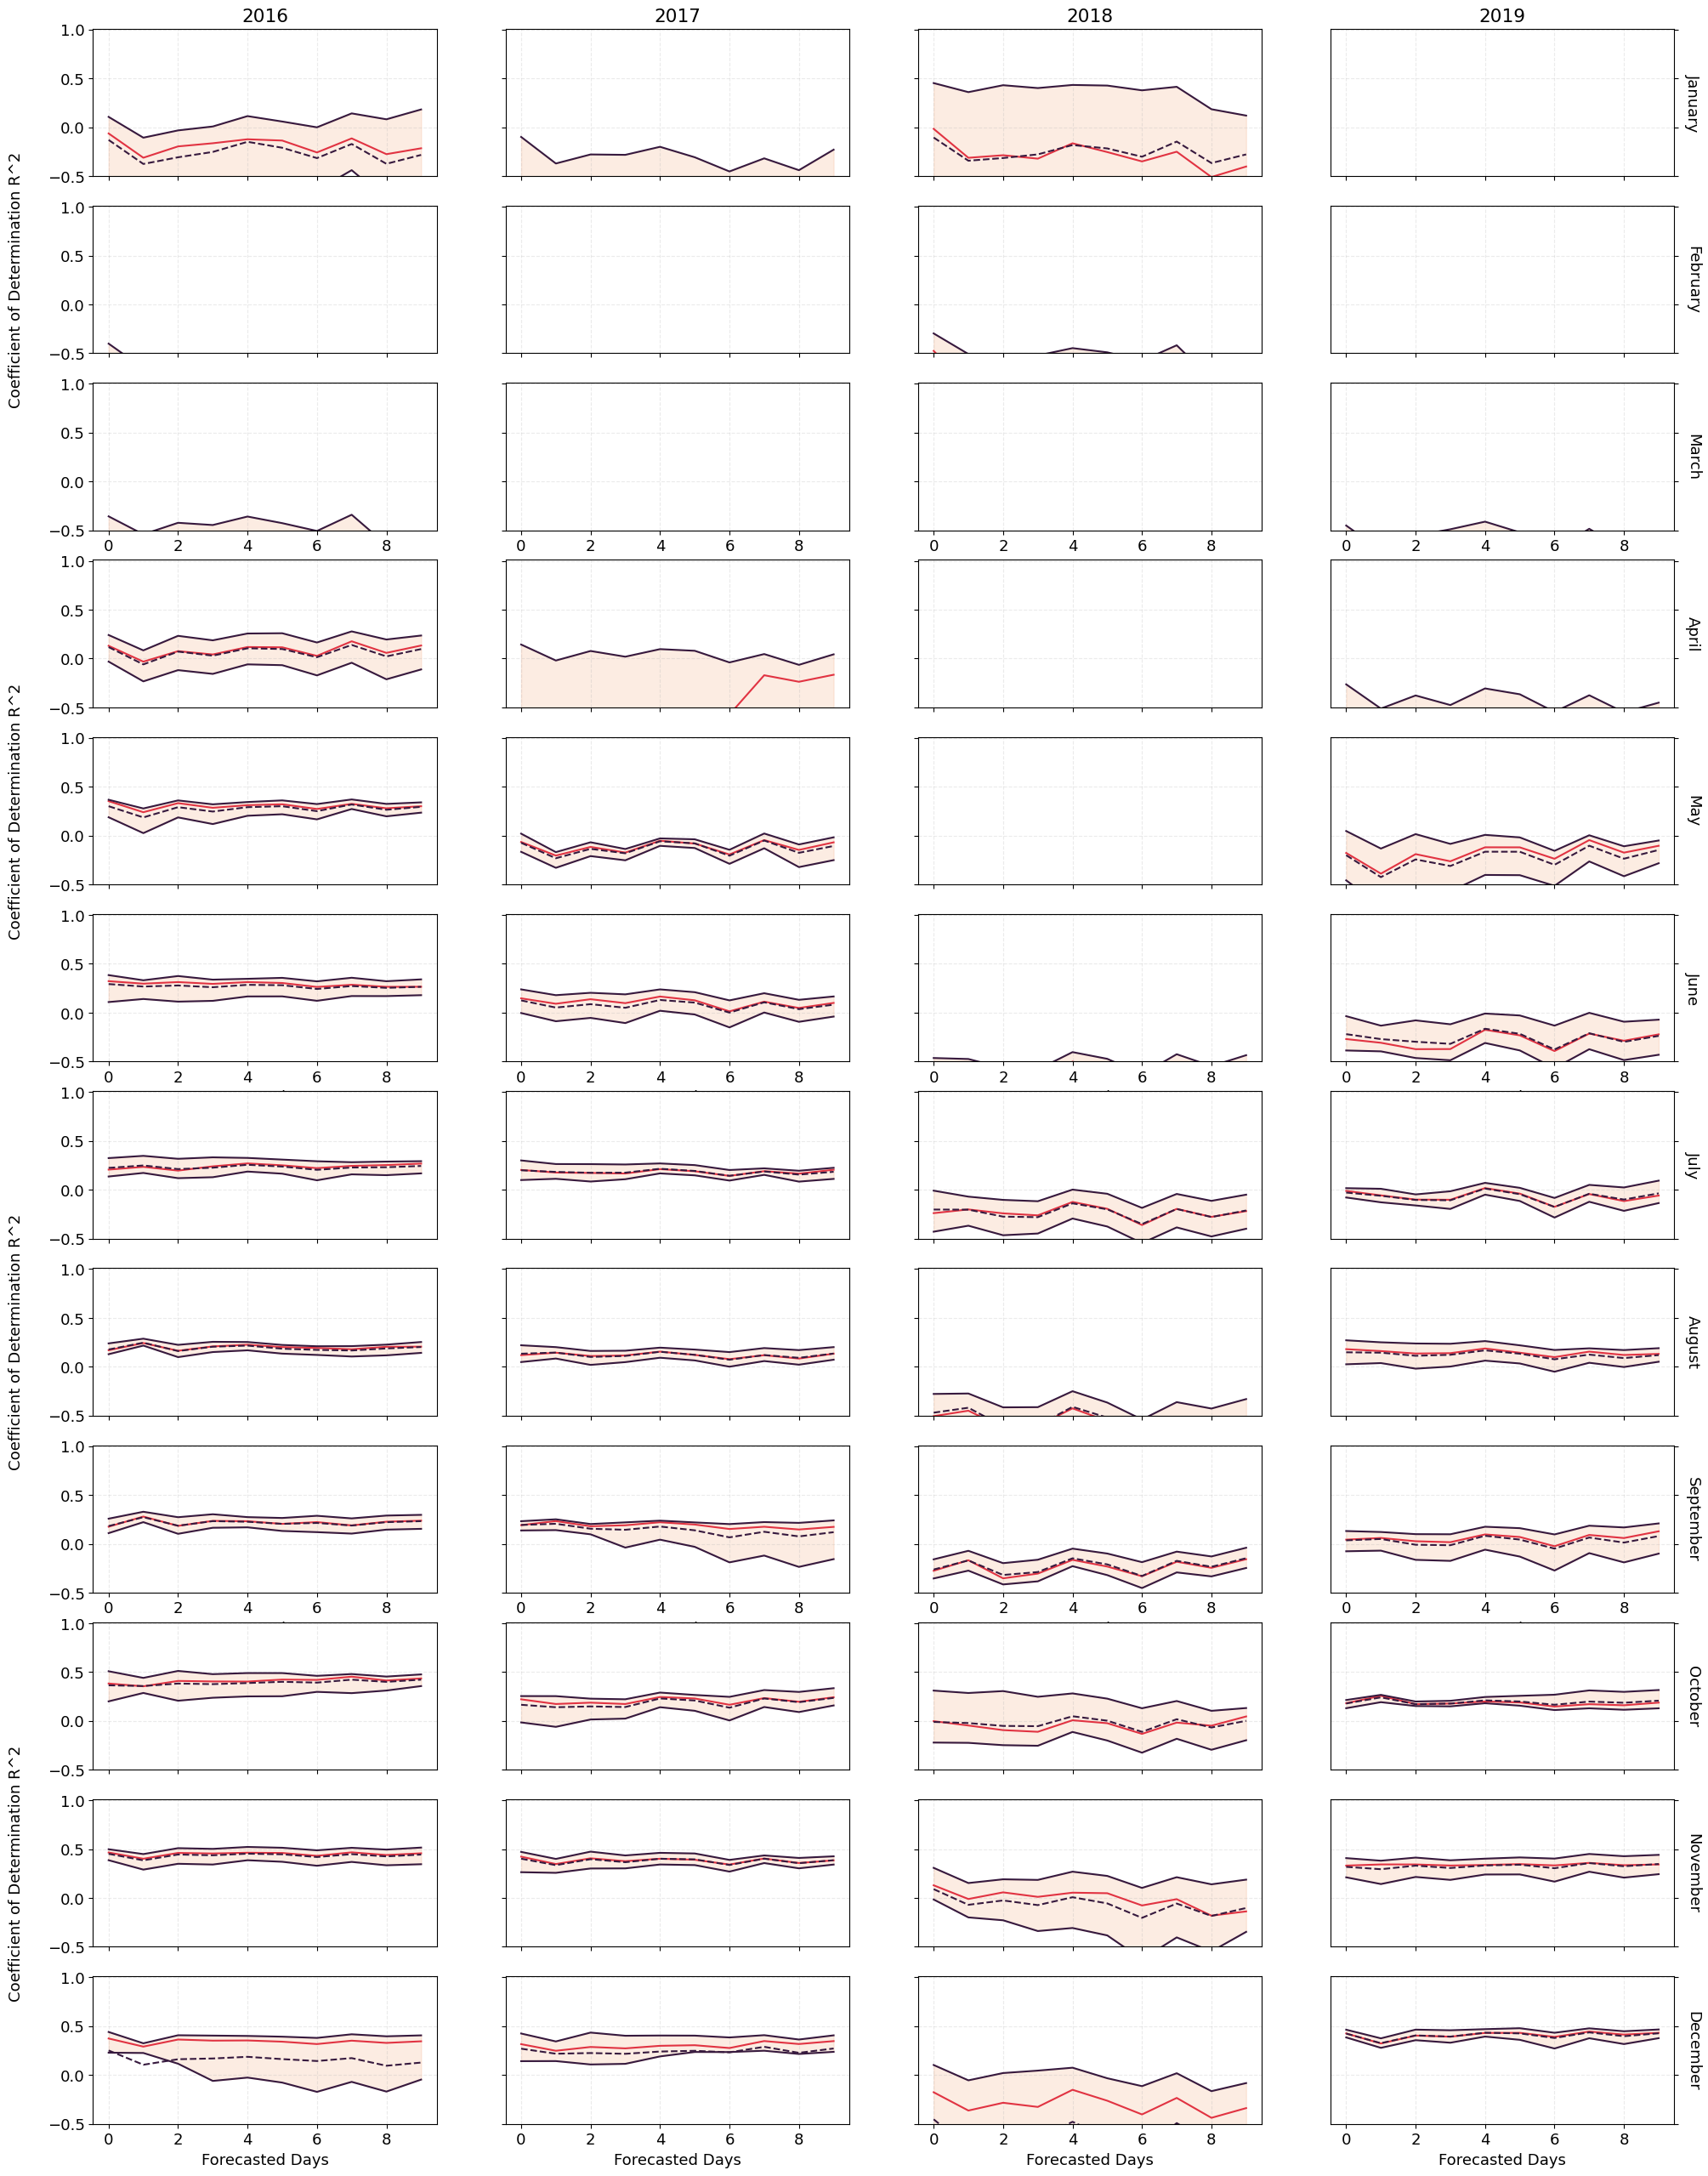

In [91]:
def analyze(y_true: torch.Tensor, y_pred: torch.Tensor, mask: np.array, dataset: BlackSea_Dataset, dataloader: BlackSea_Dataloader):
    """Used to compute a variety of metrics to evaluate the neural network"""

    def plot_seasonal_median_quantile(data: torch.Tensor, name_plot: str, name_wandb:str, ylimits: list, window_output: int, time_months: np.array, colors: list = ["#e13342", "#36193e", "#f6b48f"]):
        """Used to nicely plots the results"""

        def get_months_indices(data: np.array, window_output: int):
            """Used to extract the indices of the months, i.e. extract all the data for a given month"""

            # Conversion to torch
            data = torch.from_numpy(data)

            # Removing buffered days (beginning) and output window (end)
            data = data[365: -window_output]

            # Find the indices where the values change
            change_indices = torch.nonzero(data[:-1] != data[1:]).squeeze(1) + 1

            # Starting indices of consecutive sequences
            start_indices = torch.cat((torch.tensor([0]), change_indices))

            # Ending indices of consecutive sequences
            end_indices = torch.cat((change_indices, torch.tensor([len(data)])))

            return start_indices, end_indices

        # Extracting the dimensions of the data
        samples, forecasted_days = data.shape

        # Extrating the indices of the months
        start_indices, end_indices = get_months_indices(time_months, window_output)

        # Axis coordinates definition
        row_axis, col_axis, row_dimension = list(), list(), [i for i in range(0, 12)]

        # Circular indices
        for i in range(4):
            row_axis += row_dimension
            col_axis += [i for j in range(0, 12)]

        # Looping over different limits
        for k, lims in enumerate(ylimits):

            # Initialization of the subplots (row = months, column = years)
            fig, axs = plt.subplots(12, 4, figsize=(24,32))

            for s, e, i, j in zip(start_indices, end_indices, row_axis, col_axis):

                # Extracting the data
                data_monthly = data[s:e]

                # Computing
                data_monthly_quantiled = torch.quantile(data_monthly, torch.tensor([0.10, 0.5, 0.90]), dim = 0)
                data_monthly_mean      = torch.mean(data_monthly, dim = 0)

                # Plotting the quantiles and median
                axs[i, j].plot(data_monthly_quantiled[0], color = colors[1]) # Lower-quantile
                axs[i, j].plot(data_monthly_quantiled[1], color = colors[0]) # Median
                axs[i, j].plot(data_monthly_quantiled[2], color = colors[1]) # Upper-quantile
                axs[i, j].plot(data_monthly_mean, "--",   color = colors[1]) # Upper-quantile

                # Fixing limits
                axs[i, j].set_ylim(lims)

                # Filling the area between the quantiles
                axs[i, j].fill_between(range(10), data_monthly_quantiled[0], data_monthly_quantiled[2, :], color = colors[2], alpha = 0.25)

                # Adding a grid
                axs[i, j].grid(True, linestyle = '--', alpha = 0.25)

                # Remove x and y labels/ticks except for left edge and bottom edge
                if j not in [0]:
                    axs[i, j].set_yticklabels([])

                if j == 3:
                    axs[i, j].yaxis.tick_right()
                    axs[i, j].yaxis.set_label_position("right")

                if i not in [2, 5, 8, 11]:
                    axs[i, j].set_xticklabels([])

                # Write the month corresponding to each row on the left edge
                if j == 3:
                    axs[i, j].set_ylabel(calendar.month_name[i+1], rotation = 270, labelpad = 15)

                # Add the year of the data on top of each column
                if i == 0:
                    axs[i, j].set_title(str(2016 + j))

                # Add the xlabel
                if i in [2, 5, 8, 11]:
                    axs[i, j].set_xlabel("Forecasted Days")

                # Adding metric name
                if i in [1, 4, 7, 10] and j == 0:
                    axs[i, j].set_ylabel(name_plot, labelpad = 20)

            # WandB - Sending Results
            wandb.log({f"Analyzing - {name_wandb}/ Result {k}": wandb.Image(fig)})

    # Extracting the mean and standard deviation
    y_pred_mean = y_pred[:, :, 0]
    y_pred_std  = torch.sqrt(torch.exp(y_pred[:, :, 1]))

    # Extracting the sea values
    y_true      = y_true[:, :, mask[0] == 1]
    y_pred_mean = y_pred_mean[:, :, mask[0] == 1]
    y_pred_std  = y_pred_std[:, :, mask[0] == 1]

    # Computing metrics
    metric_RMSE = torch.sqrt(torch.nanmean((y_true - y_pred_mean) ** 2,         axis = 2))
    metric_BIAS = torch.nanmean( (y_true - y_pred_mean)/torch.absolute(y_true), axis = 2) * 100
    metric_COEF = 1 - (torch.nansum((y_true - y_pred_mean) ** 2, axis = 2))/(torch.nansum((y_true - torch.nanmean(y_true, axis = 2).unsqueeze(2)) ** 2, axis = 2))

    # Extrating temporal information
    time_days, time_months, time_years = dataset.get_time()

    # WandB - Plotting the results
    plot_seasonal_median_quantile(data        = metric_RMSE,
                                name_plot     = "Root Mean Squarred Error",
                                name_wandb    = "Root Mean Squarred Error",
                                ylimits       = [[0, 2], [0, 1], [0, 0.5], [0, 0.25], [0, 0.1]],
                                window_output = BS_loader_validation.window_output,
                                time_months   = time_months,
                                colors        = ["#e13342", "#36193e", "#f6b48f"] )

    plot_seasonal_median_quantile(data        = metric_BIAS,
                                name_plot     = "Percentage of Bias",
                                name_wandb    = "Percentage of Bias",
                                ylimits       = [[-100, 100], [-50, 50], [-25, 25], [-10, 10]],
                                window_output = BS_loader_validation.window_output,
                                time_months   = time_months,
                                colors        = ["#e13342", "#36193e", "#f6b48f"] )

    plot_seasonal_median_quantile(data        = metric_COEF,
                                name_plot     = "Coefficient of Determination R^2",
                                name_wandb    = "Coefficient of Determination R^2",
                                ylimits       = [[-0.5, 1.01]],
                                window_output = BS_loader_validation.window_output,
                                time_months   = time_months,
                                colors        = ["#e13342", "#36193e", "#f6b48f"] )


analyze(validation_ground_truth, validation_predictions, bs_mask_with_depth, validation, BS_loader_validation)

In [ ]:
y_true = validation_ground_truth
y_pred = validation_predictions
mask = bs_mask_with_depth
dataset = validation

# Extracting the mean and standard deviation
y_pred_mean = y_pred[:, :, 0]
y_pred_std  = torch.sqrt(torch.exp(y_pred[:, :, 1]))

# Extracting the sea values
y_true      = y_true[:, :, mask[0] == 1]
y_pred_mean = y_pred_mean[:, :, mask[0] == 1]
y_pred_std  = y_pred_std[:, :, mask[0] == 1]

# Computing global metrics
metric_RMSE = torch.sqrt(torch.nanmean((y_true - y_pred_mean) ** 2,         axis = 2))
metric_BIAS = torch.nanmean( (y_true - y_pred_mean)/torch.absolute(y_true), axis = 2)
metric_COEF = 1 - (torch.nansum((y_true - y_pred_mean) ** 2, axis = 2))/(torch.nansum((y_true - torch.nanmean(y_true, axis = 2).unsqueeze(2)) ** 2, axis = 2))

# Computing pearson correlation coefficient
metric_PEARSON = torch.zeros_like(metric_RMSE)

In [ ]:
coeff_determination = 1 - (torch.nansum((y_true - y_pred_mean) ** 2, axis = 2))/(torch.nansum((y_true - torch.nanmean(y_true, axis = 2).unsqueeze(2)) ** 2, axis = 2))

In [ ]:
# WandB (1) - Initialization of the run
wandb.init(project = project, mode = mode, config = kwargs)

In [ ]:
def plot_seasonal_median_quantile(data: torch.Tensor, name_plot: str, name_wandb:str, ylimits: list, window_output: int, time_months: np.array, colors: list = ["#e13342", "#36193e", "#f6b48f"]):
    "Used to nicely plots the results"

    import calendar

    def get_months_indices(data: np.array, window_output: int):
        """Used to extract the indices of the months, i.e. extract all the data for a given month"""

        # Conversion to torch
        data = torch.from_numpy(data)

        # Removing buffered days (beginning) and output window (end)
        data = data[365: -window_output]

        # Find the indices where the values change
        change_indices = torch.nonzero(data[:-1] != data[1:]).squeeze(1) + 1

        # Starting indices of consecutive sequences
        start_indices = torch.cat((torch.tensor([0]), change_indices))

        # Ending indices of consecutive sequences
        end_indices = torch.cat((change_indices, torch.tensor([len(data)])))

        return start_indices, end_indices

    # Extracting the dimensions of the data
    samples, forecasted_days = data.shape

    # Extrating the indices of the months
    start_indices, end_indices = get_months_indices(time_months, window_output)

    # Axis coordinates definition
    row_axis, col_axis, row_dimension = list(), list(), [i for i in range(0, 12)]

    # Circular indices
    for i in range(4):
        row_axis += row_dimension
        col_axis += [i for j in range(0, 12)]

    # Looping over different limits
    for k, lims in enumerate(ylimits):

        # Initialization of the subplots (row = months, column = years)
        fig, axs = plt.subplots(12, 4, figsize=(24,32))

        for s, e, i, j in zip(start_indices, end_indices, row_axis, col_axis):

            # Extracting the data
            data_monthly = data[s:e]

            # Computing
            data_monthly_quantiled = torch.quantile(data_monthly, torch.tensor([0.10, 0.5, 0.90]), dim = 0)
            data_monthly_mean      = torch.mean(data_monthly, dim = 0)

            # Plotting the quantiles and median
            axs[i, j].plot(data_monthly_quantiled[0], color = colors[1]) # Lower-quantile
            axs[i, j].plot(data_monthly_quantiled[1], color = colors[0]) # Median
            axs[i, j].plot(data_monthly_quantiled[2], color = colors[1]) # Upper-quantile
            axs[i, j].plot(data_monthly_mean, "--",   color = colors[1]) # Upper-quantile

            # Fixing limits
            axs[i, j].set_ylim(lims)

            # Filling the area between the quantiles
            axs[i, j].fill_between(range(10), data_monthly_quantiled[0], data_monthly_quantiled[2, :], color = colors[2], alpha = 0.25)

            # Adding a grid
            axs[i, j].grid(True, linestyle = '--', alpha = 0.25)

            # Remove x and y labels/ticks except for left edge and bottom edge
            if j not in [0]:
                axs[i, j].set_yticklabels([])

            if j == 3:
                axs[i, j].yaxis.tick_right()
                axs[i, j].yaxis.set_label_position("right")

            if i not in [2, 5, 8, 11]:
                axs[i, j].set_xticklabels([])

            # Write the month corresponding to each row on the left edge
            if j == 3:
                axs[i, j].set_ylabel(calendar.month_name[i+1], rotation = 270, labelpad = 15)

            # Add the year of the data on top of each column
            if i == 0:
                axs[i, j].set_title(str(2016 + j))

            # Add the xlabel
            if i in [2, 5, 8, 11]:
                axs[i, j].set_xlabel("Forecasted Days")

            # Adding metric name
            if i in [1, 4, 7, 10] and j == 0:
                axs[i, j].set_ylabel(name_plot, labelpad = 20)

        # WandB - Sending Results
        wandb.log({f"Analyzing - {name_wandb}/ Result {k}": wandb.Image(fig)})

# Extrating temporal information
time_days, time_months, time_years = dataset.get_time()

plot_seasonal_median_quantile(data          = rmse,
                              name_plot     = "Root Mean Squarred Error",
                              name_wandb    = "Root Mean Squarred Error",
                              ylimits       = [[0, 2], [0, 1], [0, 0.5], [0, 0.25], [0, 0.1]],
                              window_output = BS_loader_validation.window_output,
                              time_months   = time_months,
                              colors        = ["#e13342", "#36193e", "#f6b48f"] )

plot_seasonal_median_quantile(data          = pbias * 100,
                              name_plot     = "Percentage of Bias",
                              name_wandb    = "Percentage of Bias",
                              ylimits       = [[-100, 100], [-50, 50], [-25, 25], [-10, 10]],
                              window_output = BS_loader_validation.window_output,
                              time_months   = time_months,
                              colors        = ["#e13342", "#36193e", "#f6b48f"] )

plot_seasonal_median_quantile(data          = coeff_determination,
                              name_plot     = "Coefficient of Determination R^2",
                              name_wandb    = "Coefficient of Determination R^2",
                              ylimits       = [[-0.5, 1.01]],
                              window_output = BS_loader_validation.window_output,
                              time_months   = time_months,
                              colors        = ["#e13342", "#36193e", "#f6b48f"] )

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Data</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# Loading the different inputs
BSD_dataset = BlackSea_Dataset(year_start  = 2020,
                               year_end    = 2021,
                               month_start = 1,
                               month_end   = 12)

data_temperature   = BSD_dataset.get_data(variable = "temperature")
data_salinity      = BSD_dataset.get_data(variable = "salinity")
data_chlorophyll   = BSD_dataset.get_data(variable = "chlorophyll")
data_kshort        = BSD_dataset.get_data(variable = "kshort")
data_klong         = BSD_dataset.get_data(variable = "klong")
data_oxygen        = BSD_dataset.get_data(variable = "oxygen")
mask               = BSD_dataset.get_mask(False)
maskCS             = BSD_dataset.get_mask(True)

def generate_animation(data : np.array, mask : np.array, title : str, limits : list = [0, 1]):
    """Generate an animation of the data, i.e. used to inspect the data"""
    import os
    import cv2
    import imageio
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    from matplotlib.patches import Rectangle
    from datetime import datetime, timedelta

    # Converting to booleans for easier plot
    mask = mask > 0.5

    # Displaying information over terminal
    print(f"Data shape: {data.shape}")

    def index_to_date(i):
        """Used to convert an index to a date, i.e. useful for the title of the plot"""

        # Define the start date
        start_date = datetime(2020, 1, 1)

        # Calculate the offset from the start date
        delta = timedelta(days=i)

        # Calculate the corresponding date
        result_date = start_date + delta

        # Format the date as a string in the "YYYY-MM-DD" format
        return result_date.strftime('%Y-%m-%d')

    # Creation of a folder if it does not exist
    if not os.path.exists(f'../../analysis/images/{title}'):
        os.mkdir(f'../../analysis/images/{title}/')

    # Displaying information over terminal
    print(f"Generating images for {title}...")

    # Creating of the plots
    for i in range(data.shape[0]):
        plt.figure(figsize = (12, 8))
        plt.imshow(data[i], cmap='viridis', vmin = limits[0], vmax = limits[1])
        plt.colorbar(fraction = 0.021)
        plt.imshow(mask, cmap='gray', alpha=0.025)
        date_string = index_to_date(i)
        ax = plt.gca()
        box = Rectangle((0.85, 0.9), 0.46, 0.16, edgecolor='black', facecolor='black', transform=ax.transAxes)
        plt.annotate(date_string, xy=(0.98, 0.96), xycoords='axes fraction',
                    horizontalalignment='right', verticalalignment='top',
                    fontsize=12, color='white')
        ax.add_patch(box)
        plt.grid(True, alpha=0.1)
        plt.savefig(f'../../analysis/images/{title}/{title}_{i}.png')
        plt.close()

    # Displaying information over terminal
    print("Loading images...")

    # Creation of the paths and opening the plots
    paths = [f"../../analysis/images/{title}/{title}_{i}.png" for i in range(data.shape[0])]
    image_array = []
    for my_file in paths:
        image = Image.open(my_file)
        image_array.append(image)

    # Displaying information over terminal
    print("Generating the video...")

    # Generating the video
    with imageio.get_writer(f'../../analysis/images/{title}.gif', mode='I') as writer:
        for filename in paths:
            image = imageio.imread(filename)
            writer.append_data(image)

# Generating the animations
generate_animation(data_oxygen,      maskCS,      "oxygen", limits = [0, 1])
generate_animation(data_temperature,   mask, "temperature", limits = [0, 1])
generate_animation(data_salinity,      mask,    "salinity", limits = [0, 1])
generate_animation(data_chlorophyll,   mask, "chlorophyll", limits = [0, 0.25])
generate_animation(data_kshort,        mask,      "kshort", limits = [0, 0.1])
generate_animation(data_klong,         mask,       "klong", limits = [0, 0.1])


In [ ]:
# Loading the different inputs
BSD_dataset = BlackSea_Dataset(year_start  = 2010,
                               year_end    = 2020,
                               month_start = 1,
                               month_end   = 12)

data_oxygen        = BSD_dataset.get_data(variable = "oxygen")
mask               = BSD_dataset.get_mask(False)
maskCS             = BSD_dataset.get_mask(True)

# Extracting the training set
training_set = data_oxygen[: 365 * 6]

# Computing the mean
mean_6years = np.mean(training_set, axis = 0)

# Stores the mean each year
mean_each_year = [np.mean(data_oxygen[i * 365 : (i + 1) * 365], axis = 0) for i in range(6)]

def save_plot(data : np.array, mask : np.array, title : str):
    """Save the plot of the mean"""
    plt.figure(figsize = (12, 8))
    plt.imshow(data, cmap='viridis', vmin = 0, vmax = 1)
    plt.colorbar(fraction = 0.021)
    plt.imshow(mask, cmap='gray', alpha = 0.025)
    date_string = f"Mean : {title}"
    ax = plt.gca()
    box = Rectangle((0.80, 0.90), 0.56, 0.16, edgecolor='black', facecolor='black', transform=ax.transAxes)
    plt.annotate(date_string, xy=(0.98, 0.965), xycoords='axes fraction',
                horizontalalignment='right', verticalalignment='top',
                fontsize=12, color='white')
    ax.add_patch(box)
    plt.grid(True, alpha=0.1)
    plt.savefig(f'../../analysis/means/means_{title}.png')

# Saving the plot for all the years
save_plot(mean_6years, maskCS, "Training")

# Saving the plot for each year
for i, n in enumerate(["2010", "2011", "2012", "2013", "2014", "2015"]):
    save_plot(mean_each_year[i], maskCS, n)

# Normalized deoxygenation treshold
hypox_tresh = xarray.open_dataset(BSD_dataset.paths[0])["HYPON"].data.item()

# Computing the average state of the region (Hypoxia or not)
mean_6years_state = mean_6years < hypox_tresh

# Stores the mean each year
mean_each_year_state = [mean < hypox_tresh for mean in mean_each_year]

def save_plot_state(data : np.array, mask : np.array, title : str):
    """Save the plot of the mean"""
    plt.figure(figsize = (12, 8))
    plt.imshow(data, cmap='viridis', vmin = 0, vmax = 1)
    cbar = plt.colorbar(fraction=0.021)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Oxygenated', 'Hypoxia'])
    plt.imshow(mask, cmap='gray', alpha = 0.25)
    date_string = f"Mean : {title}"
    ax = plt.gca()
    box = Rectangle((0.80, 0.90), 0.56, 0.16, edgecolor='black', facecolor='black', transform=ax.transAxes)
    plt.annotate(date_string, xy=(0.98, 0.965), xycoords='axes fraction',
                horizontalalignment='right', verticalalignment='top',
                fontsize=12, color='white')
    ax.add_patch(box)
    plt.grid(True, alpha=0.1)
    plt.savefig(f'../../analysis/means/means_{title}.png')

# Saving the plot for all the years
save_plot_state(mean_6years_state, maskCS, "Training (H)")

# Saving the plot for each year
for i, n in enumerate(["2010 (H)", "2011 (H)", "2012 (H)", "2013 (H)", "2014 (H)", "2015 (H)"]):
    save_plot_state(mean_each_year_state[i], maskCS, n)


In [ ]:
# Sending everything to wandb
wandb.init(project = "ESA - Repport")

# Sending the animations
wandb.log({"Oxygen":              wandb.Video("../../analysis/images/oxygen.gif", fps = 1),
           "Temperature":         wandb.Video("../../analysis/images/temperature.gif", fps = 1),
           "Salinity":            wandb.Video("../../analysis/images/salinity.gif", fps = 1),
           "Chlorophyll":         wandb.Video("../../analysis/images/chlorophyll.gif", fps = 1),
           "Reflectance (Short)": wandb.Video("../../analysis/images/kshort.gif", fps = 1),
           "Reflectance (Long)" : wandb.Video("../../analysis/images/klong.gif", fps = 1)})

# Sending the mean concentrations
wandb.log({"Concentration (Mean, 2010-2015)": wandb.Image(f"../../analysis/means/means_Training.png"),
           "Concentration (Mean, 2010)":      wandb.Image(f"../../analysis/means/means_2010.png"),
           "Concentration (Mean, 2011)":      wandb.Image(f"../../analysis/means/means_2011.png"),
           "Concentration (Mean, 2012)":      wandb.Image(f"../../analysis/means/means_2012.png"),
           "Concentration (Mean, 2013)":      wandb.Image(f"../../analysis/means/means_2013.png"),
           "Concentration (Mean, 2014)":      wandb.Image(f"../../analysis/means/means_2014.png"),
           "Concentration (Mean, 2015)":      wandb.Image(f"../../analysis/means/means_2015.png")})

# Sending the mean states
wandb.log({"State (Mean, 2010-2015)": wandb.Image(f"../../analysis/means/means_Training_(H).png"),
           "State (Mean, 2010)":      wandb.Image(f"../../analysis/means/means_2010_(H).png"),
           "State (Mean, 2011)":      wandb.Image(f"../../analysis/means/means_2011_(H).png"),
           "State (Mean, 2012)":      wandb.Image(f"../../analysis/means/means_2012_(H).png"),
           "State (Mean, 2013)":      wandb.Image(f"../../analysis/means/means_2013_(H).png"),
           "State (Mean, 2014)":      wandb.Image(f"../../analysis/means/means_2014_(H).png"),
           "State (Mean, 2015)":      wandb.Image(f"../../analysis/means/means_2015_(H).png")})

# Closing the wandb session
wandb.finish()
